In [ ]:
# Function to analyze missing values
def analyze_missing_values(dataframe, name):
    print(f"\nDataset Info for {name}:")
    dataframe.info()

    # Check for missing values
    missing_values = dataframe.isnull().sum()
    empty_values = (dataframe == "").sum()
    total_missing = missing_values + empty_values
    missing_percentage = (total_missing / len(dataframe)) * 100

    # Create a summary DataFrame
    missing_summary = pd.DataFrame({
        "Missing Values": missing_values,
        "Empty Strings": empty_values,
        "Total Missing": total_missing,
        "Percentage Missing": missing_percentage
    })

    # Show only columns with missing values
    missing_summary = missing_summary[missing_summary["Total Missing"] > 0]

    print(f"\nMissing Values Summary for {name}:")
    display(missing_summary.sort_values(by="Percentage Missing", ascending=False))

    # Visualizing missing data
    plt.figure(figsize=(12, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap="viridis")
    plt.title(f"Missing Data Heatmap for {name}")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d, grey_closing
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math



def clean_univariate_bootstrap_density_weighted(
    dataframes_dict,
    ilr_columns,
    composition_columns,
    phase_columns=None,
    thresholds=None,
    n_bins=100,
    max_memory_gb=12,
    dtype="float64",
    verbose=True,
    bootstrap="auto",
    n_bootstrap="auto",
    only_threshold=None,
    pect_prominence=0.05,
    weight=None,
    filtering = True
):

    if phase_columns is None:
        phase_columns = []

    cleaned_dfs = {}

    for name, df in dataframes_dict.items():
        start_time = time.time()
        if verbose:
            print(f"\n🚀 Cleaning '{name}' using univariate mountain-based density filtering...")

        columns_to_check = ilr_columns + phase_columns
        columns_to_check = [col for col in columns_to_check if col in df.columns]
        valid_mask = df[columns_to_check].notna().all(axis=1)

        # If using weights, also check for NaNs in weight column
        if weight:
            valid_mask &= df[weight].notna()

        df_cleaned = df.loc[valid_mask].copy()

        # ──────────────────────────────────────────────────────────────
        # NEW → start with “keep everything” for all cleaned rows
        n_rows = df_cleaned.shape[0]
        global_keep_mask = np.ones(n_rows, dtype=bool)

        # optional: to preserve cluster labels until final filtering
        cluster_labels_dict = {}      # {col_name: full-length array}
        # ──────────────────────────────────────────────────────────────


        # ✅ Dynamically resolve bootstrap after filtering NaNs
        n_samples_cleaned = df_cleaned.shape[0]

        if bootstrap == "auto":
            bootstrap = n_samples_cleaned < 1000
            if verbose:
                print(f"   ➤ Bootstrap auto-evaluated: {bootstrap}  (cleaned samples = {n_samples_cleaned})")

        for col in columns_to_check:
            col_start_time = time.time()

            weights = df_cleaned[weight].values.astype(dtype) if weight else None
            original_values = df_cleaned[col].values.astype(dtype)
            original_plot_weights = df_cleaned[weight].values.astype(dtype) if weight else None

            n_samples = len(original_values)

            if verbose:
                print(f"\n🔍 Processing column: {col}")
                print(f"   ➤ Original sample count: {n_samples}")
                print(f"   ➤ Bootstrap set to: {bootstrap}")
                print(f"   ➤ Weight set to: {weight}")

            # Use bootstrapped values only for histogram/peak detection
            if bootstrap:
                if n_bootstrap == "auto":
                    if n_samples < 500:
                        n_boot = 5000
                    elif n_samples < 800:
                        n_boot = 3000
                    else:
                        n_boot = 2000
                else:
                    n_boot = n_bootstrap

                if verbose:
                    print(f"📦 Using n_boot = {n_boot} resamples")

                # Sampling indices with or without weight
                bootstrap_indices = np.concatenate([
                    np.random.choice(n_samples, size=n_samples, replace=True)
                    for _ in range(n_boot)
                ])
                bootstrap_values = original_values[bootstrap_indices]

            else:
                bootstrap_values = original_values  # fallback if no bootstrapping

            # Histogram (weighted or not)
            # Step: Generate both histograms if bootstrap is used
            # ------------------------------------

            # Histogram for original values
            if weight:
                hist_original, bin_edges = np.histogram(
                    original_values,
                    bins=n_bins,
                    weights=weights,
                    density=True
                )
            else:
                hist_original, bin_edges = np.histogram(
                    original_values,
                    bins=n_bins,
                    density=True
                )

            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            # Histogram for bootstrapped values (used for peak detection)
            if bootstrap:
                if weight:
                    sample_weights = np.tile(weights, n_boot)
                    hist_bootstrap, _ = np.histogram(
                        bootstrap_values,
                        bins=bin_edges,
                        weights=sample_weights,
                        density=True
                    )
                else:
                    hist_bootstrap, _ = np.histogram(
                        bootstrap_values,
                        bins=bin_edges,
                        density=True
                    )
            else:
                hist_bootstrap = hist_original  # fallback to original
                bootstrap_values = original_values  # safety if plotting later


            # === Define smoothing constants ===
            gradient_threshold = 0.05
            window_ratio = 1 / 40
            min_window_bins = 3
            min_sigma = 1
            max_sigma = 5

            base_sigma_bootstrap = 1.25 if col in phase_columns else 1.0
            base_sigma_original = 1.5 if col in phase_columns else 1.25

            # === Adaptive smoothing function ===
            def adaptive_smoothing(hist, base_sigma, label=""):
                window_raw = int(len(hist) * window_ratio)
                window = max(min_window_bins, window_raw)
                half_window = window # window // 2

                if verbose:
                    print(f"   ➤ Window ({label}): {'MIN' if window == min_window_bins else f'{window} (from {window_raw})'} bins")

                # === Detect not-isolated zero bins ===
                n_not_isolated_zeros = 0
                for i in range(half_window, len(hist) - half_window):
                    if hist[i] == 0:
                        left = hist[i - half_window:i]
                        right = hist[i + 1:i + 1 + half_window]
                        if np.any(left > 0) or np.any(right > 0):
                            n_not_isolated_zeros += 1

                gap_pct = 100 * n_not_isolated_zeros / len(hist)
                dyn_percentile = min(98, 90 + gap_pct)

                if verbose:
                    print(f"   ➤ Not-isolated 0 bins: {n_not_isolated_zeros} / {len(hist)} ({gap_pct:.2f}%)")
                    print(f"   ➤ Using dynamic percentile: {dyn_percentile:.2f}%")

                # === Gradient stats over window range ===
                gradients = np.array([
                    np.abs(hist[i + half_window] - hist[i - half_window])
                    for i in range(half_window, len(hist) - half_window)
                ])
                grad_stat = np.percentile(gradients, dyn_percentile)

                if grad_stat > gradient_threshold:
                    inflation = (1 / math.sqrt(grad_stat)) * (grad_stat - gradient_threshold)
                    smoothing_sigma = base_sigma * (1 + inflation**2)

                    if smoothing_sigma < min_sigma:
                        if verbose:
                            print(f"   ➤ σ clamped to MIN ({label}): {smoothing_sigma:.4f} → {min_sigma}")
                        smoothing_sigma = min_sigma
                    elif smoothing_sigma > max_sigma:
                        if verbose:
                            print(f"   ➤ σ clamped to MAX ({label}): {smoothing_sigma:.4f} → {max_sigma}")
                        smoothing_sigma = max_sigma
                    else:
                        if verbose:
                            print(f"   ➤ σ adjusted ({label}): {smoothing_sigma:.4f}")

                    hist_proc = grey_closing(hist.astype(float), size=3)
                    closing_applied = True
                else:
                    smoothing_sigma = base_sigma
                    hist_proc = hist
                    closing_applied = False
                    if verbose:
                        print(f"   ➤ σ kept base ({label}): {smoothing_sigma:.2f}")

                if verbose:
                    print(f"   ➤ Gradient ({dyn_percentile:.2f}th %ile) ({label}): {grad_stat:.4f} → σ = {smoothing_sigma:.2f} | Closing: {'Yes' if closing_applied else 'No'}")

                smoothed = gaussian_filter1d(hist_proc, sigma=smoothing_sigma)
                return smoothed



            # === Apply adaptive smoothing ===
            smoothed_hist_original = adaptive_smoothing(hist_original, base_sigma_original, label="Original")
            if bootstrap:
                smoothed_hist_bootstrap = adaptive_smoothing(hist_bootstrap, base_sigma_bootstrap, label="Bootstrap")
            else:
                smoothed_hist_bootstrap = smoothed_hist_original.copy()




            # Use the bootstrap version for peak detection logic
            max_density = hist_bootstrap.max()
            prominence_threshold = max_density * 0.01  # for peak detection
            bin_width = bin_edges[1] - bin_edges[0]
            total_mass = np.sum(smoothed_hist_bootstrap) * bin_width
            total_mass_original = np.sum(hist_original) * bin_width

            # --- Peak Detection ---
            peaks, properties = find_peaks(
                smoothed_hist_bootstrap,
                prominence=prominence_threshold,
                distance=max(1, (n_bins * 3) // 20)
            )

            # Keep peaks based on prominence of total mass
            peak_mask = []
            discarded_peaks = []

            # Define dynamic window size (1/10 of n_bins)
            if n_bins < 100:
                window_size = int(np.ceil(n_bins / 20))
            else:
                window_size = int(np.floor(n_bins / 20))

            for peak in peaks:
                start = max(0, peak - window_size)
                end = min(len(smoothed_hist_bootstrap), peak + window_size + 1)  # +1 because slice is exclusive

                # Area in smoothed bootstrap hist
                peak_area_smoothed = np.sum(smoothed_hist_bootstrap[start:end]) * bin_width
                peak_fraction_smoothed = peak_area_smoothed / total_mass

                # Area in original hist
                peak_area_original = np.sum(hist_original[start:end]) * bin_width
                peak_fraction_original = peak_area_original / total_mass_original

                if (peak_fraction_smoothed >= pect_prominence) and (peak_fraction_original >= pect_prominence):
                    peak_mask.append(True)
                else:
                    peak_mask.append(False)
                    discarded_peaks.append(peak)


            # Apply mask
            peaks = peaks[np.asarray(peak_mask, dtype=bool)]

            # Merge close peaks if valley not deep enough
            valley_threshold = 0.5
            i = 0
            while i < len(peaks) - 1:
                current = peaks[i]
                j = i + 1
                merged = False
                while j < len(peaks):
                    left = current
                    right = peaks[j]
                    h_left = smoothed_hist_bootstrap[left]
                    h_right = smoothed_hist_bootstrap[right]

                    valley_means = [
                        np.mean(smoothed_hist_bootstrap[k - 1: k + 2])
                        for k in range(left + 1, right - 1)
                    ]
                    valley = min(valley_means) if valley_means else np.min(smoothed_hist_bootstrap[left:right + 1])
                    peak_ratio = min(h_left, h_right) / max(h_left, h_right)
                    divisor = min(h_left, h_right) if peak_ratio < 0.5 else 0.5 * (h_left + h_right)
                    valley_ratio = valley / divisor

                    if valley_ratio > valley_threshold:
                        drop_peak = left if h_left < h_right else right
                        discarded_peaks.append(drop_peak)
                        peaks = peaks[peaks != drop_peak]
                        merged = True
                        break
                    j += 1
                if not merged:
                    i += 1



            # Step 4: Print info and plot
                        # Step 4: Print info and plot
            if verbose:
                print(f"{col} — Pect_Prominence = {pect_prominence} | Prominence Threshold = {prominence_threshold:.4f} ({0.01 * 100:.2f}% of peak height)")

                # Estimate bin width
                bin_width = bin_edges[1] - bin_edges[0]

                # Recalculate heights without plotting, for consistency
                if weight:
                    hist_heights_original, _ = np.histogram(
                        original_values,
                        bins=bin_edges,
                        weights=original_plot_weights,
                        density=True
                    )
                else:
                    hist_heights_original, _ = np.histogram(
                        original_values,
                        bins=bin_edges,
                        density=True
                    )

                max_density_original = hist_heights_original.max()

                max_density_pct = max_density_original * bin_width * 100
                prominence_density_pct = prominence_threshold * bin_width * 100

                print(f"   ➤ Max bin density ≈ {max_density_pct:.2f}% of total samples")
                print(f"   ➤ Prominence threshold ≈ {prominence_density_pct:.2f}% of total samples")
                print(f"   ➤ Density threshold ≈ {pect_prominence * 100:.2f}% of total samples")

                # Common Y-axis config for original
                temp_pect = pect_prominence
                y_max_orig = max_density_original * (1 + temp_pect)
                percent_levels = np.arange(0, 100 + (temp_pect * 100), temp_pect * 100)
                ticks_orig = (percent_levels / 100) * max_density_original
                tick_labels_orig = [f"{p:>5.2f}% - {v:.3f}" for p, v in zip(percent_levels, ticks_orig)]

                # ----- Plot 1: Original Histogram -----
                plt.figure(figsize=(10, 6))
                plt.hist(
                    original_values,
                    bins=n_bins,
                    density=True,
                    weights=original_plot_weights,
                    color="steelblue",
                    alpha=0.6,
                    edgecolor="black",
                    label="Original Histogram"
                )

                # Overlay smoothed histogram from ORIGINAL
                plt.plot(
                    bin_centers,
                    smoothed_hist_original,
                    color="darkorange",
                    linewidth=2,
                    label="Smoothed (Original)"
                )

                # Overlay smoothed histogram from BOOTSTRAP
                if bootstrap:
                    plt.plot(
                        bin_centers,
                        smoothed_hist_bootstrap,
                        color="mediumvioletred",
                        linewidth=2,
                        linestyle="--",
                        label="Smoothed (Bootstrap)"
                    )

                # Always plot on original smoothed line
                if len(peaks) > 0:
                    plt.scatter(
                        bin_centers[peaks],
                        smoothed_hist_original[peaks],
                        color="red",
                        s=60,
                        zorder=5,
                        label="Detected Peaks (Original)"
                    )

                if len(discarded_peaks) > 0:
                    plt.scatter(
                        bin_centers[discarded_peaks],
                        smoothed_hist_original[discarded_peaks],
                        color="green",
                        s=60,
                        zorder=5,
                        label="Discarded Peaks (Original)"
                    )

                # If bootstrap is on, also overlay peaks on bootstrap line
                if bootstrap:
                    if len(peaks) > 0:
                        plt.scatter(
                            bin_centers[peaks],
                            smoothed_hist_bootstrap[peaks],
                            color="red",
                            s=60,
                            zorder=5,
                            marker="x",
                            label="Detected Peaks (Bootstrap)"
                        )

                    if len(discarded_peaks) > 0:
                        plt.scatter(
                            bin_centers[discarded_peaks],
                            smoothed_hist_bootstrap[discarded_peaks],
                            color="green",
                            s=60,
                            zorder=5,
                            marker="x",
                            label="Discarded Peaks (Bootstrap)"
                        )


                plt.ylim(0, y_max_orig)
                plt.yticks(ticks_orig, tick_labels_orig)
                plt.title(f"{col} — Original Distribution")
                plt.xlabel(col)
                plt.ylabel("Density")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

                # ----- Plot 2: Bootstrapped Histogram + Smoothed (if enabled) -----
                if bootstrap:
                    if weight and weight in df_cleaned.columns:
                        bootstrap_plot_weights = original_plot_weights[bootstrap_indices]
                    else:
                        bootstrap_plot_weights = None

                    # Compute bar heights for bootstrapped histogram (without plotting)
                    if weight:
                        hist_heights, _ = np.histogram(
                            bootstrap_values,
                            bins=bin_edges,
                            weights=bootstrap_plot_weights,
                            density=True
                        )
                    else:
                        hist_heights, _ = np.histogram(
                            bootstrap_values,
                            bins=bin_edges,
                            density=True
                        )

                    # Use this for Y-axis scaling
                    max_bar_height = hist_heights.max()
                    y_max_bootstrap = max_bar_height * (1 + temp_pect)
                    ticks_bootstrap = (percent_levels / 100) * max_bar_height
                    tick_labels_bootstrap = [f"{p:>5.2f}% - {v:.3f}" for p, v in zip(percent_levels, ticks_bootstrap)]



                    plt.figure(figsize=(10, 6))
                    plt.hist(
                        bootstrap_values,
                        bins=bin_edges,
                        density=True,
                        weights=bootstrap_plot_weights,
                        color="skyblue",
                        alpha=0.6,
                        edgecolor="black",
                        label="Bootstrapped Histogram"
                    )

                    # Overlay smoothed histogram from BOOTSTRAP
                    plt.plot(
                        bin_centers,
                        smoothed_hist_bootstrap,
                        color="mediumvioletred",
                        linewidth=2,
                        label="Smoothed (Bootstrap)"
                    )

                    # Overlay smoothed histogram from ORIGINAL
                    plt.plot(
                        bin_centers,
                        smoothed_hist_original,
                        color="darkorange",
                        linewidth=2,
                        linestyle="--",
                        label="Smoothed (Original)"
                    )

                    # Bootstrap peaks on bootstrap line
                    if len(peaks) > 0:
                        plt.scatter(
                            bin_centers[peaks],
                            smoothed_hist_bootstrap[peaks],
                            color="red",
                            s=60,
                            zorder=5,
                            label="Detected Peaks (Bootstrap)"
                        )

                    if len(discarded_peaks) > 0:
                        plt.scatter(
                            bin_centers[discarded_peaks],
                            smoothed_hist_bootstrap[discarded_peaks],
                            color="green",
                            s=60,
                            zorder=5,
                            label="Discarded Peaks (Bootstrap)"
                        )

                    # Overlay same peaks on original smoothed line for reference
                    if len(peaks) > 0:
                        plt.scatter(
                            bin_centers[peaks],
                            smoothed_hist_original[peaks],
                            color="red",
                            s=60,
                            zorder=5,
                            marker="x",
                            label="Detected Peaks (Original)"
                        )

                    if len(discarded_peaks) > 0:
                        plt.scatter(
                            bin_centers[discarded_peaks],
                            smoothed_hist_original[discarded_peaks],
                            color="green",
                            s=60,
                            zorder=5,
                            marker="x",
                            label="Discarded Peaks (Original)"
                        )


                    plt.ylim(0, y_max_bootstrap)
                    plt.yticks(ticks_bootstrap, tick_labels_bootstrap)
                    plt.title(f"{col} — Bootstrapped + Smoothed (Peak Detection)")
                    plt.xlabel(col)
                    plt.ylabel("Density")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()


            hist = hist_original

            if len(peaks) < 1:
                if verbose:
                    print(f"⚠️ No peaks detected for {col}, applying low-density filtering...")

                if only_threshold is None:
                    only_threshold = 0.99

                main_peak_idx = np.argmax(hist)
                main_peak_density = hist[main_peak_idx]
                total_mass = hist.sum()

                if verbose:
                    print(f"🔹 Main peak at bin {main_peak_idx} with density {main_peak_density}")
                    print(f"🔸 Total mass (sum of all bin frequencies): {total_mass}")

                # Penalty: lower density and farther from the main peak
                penalties = []
                for i in range(len(hist)):
                    density = hist[i]
                    distance = abs(i - main_peak_idx)
                    score = (1 / (density + 1e-8)) * (1 + distance)
                    penalties.append((score, i))

                sorted_bins = [i for _, i in sorted(penalties, key=lambda x: x[0])]

                keep_mask = np.zeros_like(hist, dtype=bool)
                accumulated = 0
                for idx in sorted_bins:
                    if accumulated / total_mass >= only_threshold:
                        break
                    keep_mask[idx] = True
                    accumulated += hist[idx]

                bin_indices = np.clip(np.digitize(original_values, bin_edges) - 1, 0, len(hist) - 1)
                value_keep_mask = keep_mask[bin_indices]

                kept_n = value_keep_mask.sum()
                removed_n = len(original_values) - kept_n
                retained_ratio = kept_n / len(original_values)

                if verbose:
                    print(f"📌 {col}: Retained {retained_ratio*100:.2f}% of samples → {kept_n}/{len(original_values)} kept, {removed_n} removed.")

                    # Plot filtered histogram of original values
                    plt.figure(figsize=(10, 6))

                    plt.hist(
                        original_values[value_keep_mask],
                        bins=n_bins,
                        density=True,
                        weights=original_plot_weights[value_keep_mask] if weight else None,
                        color="orange",
                        edgecolor="black",
                        alpha=0.8,
                        label="Filtered"
                    )


                    # Recalculate histogram heights for filtered values
                    if weight:
                        hist_filtered, _ = np.histogram(
                            original_values[value_keep_mask],
                            bins=n_bins,
                            weights=original_plot_weights[value_keep_mask],
                            density=True
                        )
                    else:
                        hist_filtered, _ = np.histogram(
                            original_values[value_keep_mask],
                            bins=n_bins,
                            density=True
                        )

                    max_density_filtered = hist_filtered.max()

                    # Y-axis config
                    temp_pect = pect_prominence
                    y_max = max_density_filtered * (1 + temp_pect)
                    percent_levels = np.arange(0, 100 + (temp_pect * 100), temp_pect * 100)
                    ticks = (percent_levels / 100) * max_density_filtered
                    tick_labels = [f"{p:>5.2f}% - {v:.3f}" for p, v in zip(percent_levels, ticks)]


                    plt.ylim(0, y_max)
                    plt.yticks(ticks, tick_labels)

                    plt.title(f"{col} — Filtered (No Peaks) with threshold = {only_threshold}")
                    plt.xlabel(col)
                    plt.ylabel("Density")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()



                # ── OLD ─────────────────────────────────────────────────────────
                # df_cleaned = df_cleaned.loc[value_keep_mask]
                # df_cleaned[f"{col}_cluster"] = 0
                # continue
                # ── NEW ─────────────────────────────────────────────────────────
                global_keep_mask &= value_keep_mask        # ❶ accumulate

                # store cluster labels (0 for kept rows, NaN for dropped)
                cluster_full = np.full(n_rows, np.nan)
                cluster_full[value_keep_mask] = 0
                cluster_labels_dict[col] = cluster_full

                continue


            elif len(peaks) == 1:
                if verbose:
                    print(f"⚠️ Only one peak found for {col}, applying centered filtering...")

                if only_threshold is None:
                    only_threshold = 0.99

                main_peak_idx = peaks[0]
                main_peak_density = hist[main_peak_idx]
                total_mass = hist.sum()

                if verbose:
                    print(f"🔹 Single peak at bin {main_peak_idx} with density {main_peak_density}")
                    print(f"🔸 Total mass (sum of all bin frequencies): {total_mass:.2f}")

                # Penalty: prioritize bins with lower density and farther from the peak
                penalties = []
                for i in range(len(hist)):
                    density = hist[i]
                    distance = abs(i - main_peak_idx)
                    score = (1 / (density + 1e-8)) * (1 + distance)
                    penalties.append((score, i))

                sorted_bins = [i for _, i in sorted(penalties, key=lambda x: x[0])]

                keep_mask = np.zeros_like(hist, dtype=bool)
                accumulated = 0
                for idx in sorted_bins:
                    if accumulated / total_mass >= only_threshold:
                        break
                    keep_mask[idx] = True
                    accumulated += hist[idx]

                # Apply to original values
                bin_indices = np.clip(np.digitize(original_values, bin_edges) - 1, 0, len(hist) - 1)
                value_keep_mask = keep_mask[bin_indices]

                kept_n = value_keep_mask.sum()
                removed_n = len(original_values) - kept_n
                retained_ratio = kept_n / len(original_values)

                if verbose:
                    print(f"📌 {col}: Retained {retained_ratio*100:.2f}% of samples → {kept_n}/{len(original_values)} kept, {removed_n} removed.")

                    # Plot filtered histogram (original values after filtering)
                    plt.figure(figsize=(10, 6))

                    plt.hist(
                        original_values[value_keep_mask],
                        bins=n_bins,
                        density=True,
                        weights=original_plot_weights[value_keep_mask] if weight else None,
                        color="orange",
                        edgecolor="black",
                        alpha=0.8,
                        label="Filtered"
                    )

                    # Recalculate histogram height for filtered values
                    if weight:
                        hist_filtered, _ = np.histogram(
                            original_values[value_keep_mask],
                            bins=n_bins,
                            weights=original_plot_weights[value_keep_mask],
                            density=True
                        )
                    else:
                        hist_filtered, _ = np.histogram(
                            original_values[value_keep_mask],
                            bins=n_bins,
                            density=True
                        )

                    max_density_filtered = hist_filtered.max()

                    # Use filtered max for correct scaling
                    temp_pect = pect_prominence
                    y_max = max_density_filtered * (1 + temp_pect)
                    percent_levels = np.arange(0, 100 + (temp_pect * 100), temp_pect * 100)
                    ticks = (percent_levels / 100) * max_density_filtered
                    tick_labels = [f"{p:>5.2f}% - {v:.3f}" for p, v in zip(percent_levels, ticks)]


                    plt.ylim(0, y_max)
                    plt.yticks(ticks, tick_labels)

                    plt.title(f"{col} — Filtered (1 Peak) with threshold = {only_threshold}")
                    plt.xlabel(col)
                    plt.ylabel("Density")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()




                # ── OLD ─────────────────────────────────────────────────────────
                # df_cleaned = df_cleaned.loc[value_keep_mask]
                # df_cleaned[f"{col}_cluster"] = 0
                # continue
                # ── NEW ─────────────────────────────────────────────────────────
                global_keep_mask &= value_keep_mask        # ❶ accumulate

                cluster_full = np.full(n_rows, np.nan)
                cluster_full[value_keep_mask] = 0
                cluster_labels_dict[col] = cluster_full

                continue


            elif len(peaks) > 1:
                if verbose:
                    print(f"🔍 Found {len(peaks)} peaks for {col}, applying threshold-based filtering with silhouette optimization.")

                if thresholds is None:
                    thresholds = [0.9825, 0.9875, 0.99, 0.9925, 0.995, 0.9975, 1]

                best_score = -np.inf
                best_keep_mask = None
                best_labels_hist = None
                best_threshold = None

                for threshold in thresholds:
                    total_mass = hist.sum()

                    # Penalty score based on density and distance to closest peak
                    penalties = []
                    for i in range(len(hist)):
                        distances = [abs(i - p) for p in peaks]
                        min_distance = min(distances)
                        penalty = (1 / (hist[i] + 1e-8)) * (1 + min_distance)
                        penalties.append((penalty, i))

                    sorted_bins = [i for _, i in sorted(penalties, key=lambda x: x[0])]

                    # Create keep mask
                    keep_mask = np.zeros_like(hist, dtype=bool)
                    accumulated = 0
                    for idx in sorted_bins:
                        if accumulated / total_mass >= threshold:
                            break
                        keep_mask[idx] = True
                        accumulated += hist[idx]

                    # Assign bin labels by peak proximity
                    labels = np.zeros_like(hist, dtype=int)
                    for i in range(len(hist)):
                        distances = [abs(i - p) for p in peaks]
                        labels[i] = np.argmin(distances)

                    filtered_labels = labels.copy()
                    filtered_labels[~keep_mask] = -1

                    # Apply filtering to original values (not bootstrap)
                    bin_indices = np.clip(np.digitize(original_values, bin_edges) - 1, 0, len(hist) - 1)
                    value_labels = filtered_labels[bin_indices]
                    mask_valid = value_labels != -1

                    if len(np.unique(value_labels[mask_valid])) < 2:
                        continue

                    # Determine sample size for silhouette
                    n_samples = len(original_values[mask_valid])
                    use_subsample = n_samples > 10000
                    sample_size = 10000 if use_subsample else None

                    if verbose:
                        print(f"📏 Silhouette: using {'ALL' if sample_size is None else sample_size} out of {n_samples} samples")

                    score = silhouette_score(
                        original_values[mask_valid].reshape(-1, 1),
                        value_labels[mask_valid],
                        sample_size=sample_size,           # Only used if subsampling
                        random_state=42 if use_subsample else None  # Only matters if subsampling
                    )


                    alpha = 0.65
                    kept_ratio = len(original_values[mask_valid]) / len(original_values)
                    adjusted_score = score * (kept_ratio ** alpha)

                    if adjusted_score > best_score:
                        best_score = adjusted_score
                        best_keep_mask = mask_valid
                        best_labels_hist = filtered_labels
                        best_threshold = threshold

                if best_keep_mask is None:
                    if verbose:
                        print(f"⚠️ No valid segmentation found for {col}.")
                    continue

                # --- OLD lines to remove / replace ---------------------------------
                # filtered_values = original_values[best_keep_mask]
                # before_n = df_cleaned.shape[0]
                # df_cleaned = df_cleaned.loc[best_keep_mask]
                # removed_pct = 100 * (before_n - df_cleaned.shape[0]) / before_n
                #
                # bin_indices_final = ...
                # cluster_labels = ...
                # df_cleaned[f"{col}_cluster"] = cluster_labels
                # -------------------------------------------------------------------

                # ❶ Keep filtered values just for plots / summaries
                filtered_values = original_values[best_keep_mask]
                filtered_weights = original_plot_weights[best_keep_mask] if weight else None

                # ❷ Accumulate the mask instead of shrinking df_cleaned now
                global_keep_mask &= best_keep_mask

                # ❸ Prepare full-length cluster label array (NaN for rows that will be dropped)
                cluster_full = np.full(n_rows, np.nan)
                bin_indices_final = np.clip(np.digitize(original_values, bin_edges) - 1, 0, len(hist) - 1)
                cluster_labels = best_labels_hist[bin_indices_final]
                cluster_full[best_keep_mask] = cluster_labels[best_keep_mask]
                cluster_labels_dict[col] = cluster_full

                # ➍ For verbose “removed %”, compute using the global mask so far
                before_n = n_rows
                after_n  = global_keep_mask.sum()
                removed_pct = 100 * (before_n - after_n) / before_n



                if verbose:
                    print(f"✅ {col}: Best threshold={best_threshold}, Silhouette={best_score:.4f}, Alpha={alpha}, Removed {removed_pct:.2f}%")
                    print(f"⏱️ Column time: {time.time() - col_start_time:.2f} seconds.")

                    # Plot filtered bins from original data
                    plt.figure(figsize=(10, 6))
                    for label in np.unique(best_labels_hist[best_labels_hist != -1]):
                        mask = best_labels_hist == label
                        plt.bar(
                            bin_centers[mask],
                            hist[mask],
                            width=bin_edges[1] - bin_edges[0],
                            alpha=0.6,
                            edgecolor="black",
                            label=f"Mountain {label + 1}"
                        )

                    # Use temp_pect for consistent y-axis setup
                    temp_pect = pect_prominence
                    y_max = hist.max() * (1 + temp_pect)
                    percent_levels = np.arange(0, 100 + (temp_pect * 100), temp_pect * 100)
                    ticks = (percent_levels / 100) * hist.max()
                    tick_labels = [f"{p:>5.2f}% - {v:.3f}" for p, v in zip(percent_levels, ticks)]

                    plt.ylim(0, y_max)
                    plt.yticks(ticks, tick_labels)

                    plt.title(f"{col} — Filtered with Best Threshold = {best_threshold}")
                    plt.xlabel(col)
                    plt.ylabel("Density")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

                    # Filtered values and aligned weights
                    filtered_values = original_values[best_keep_mask]
                    filtered_weights = original_plot_weights[best_keep_mask] if weight else None



        # ───────── FINAL UNION / ATTACH CLUSTERS ───────────────────────
        if filtering:
            # really drop rows that failed any column mask
            df_cleaned = df_cleaned.loc[global_keep_mask].copy()

        # add a <col>_cluster column for every processed feature
        for col, full_labels in cluster_labels_dict.items():
            if filtering:
                # keep only the rows that survived
                df_cleaned[f"{col}_cluster"] = full_labels[global_keep_mask]
            else:
                # keep ALL rows; rows that would have been dropped get label –1
                labels_out = full_labels.copy()
                labels_out[np.isnan(labels_out)] = -1
                df_cleaned[f"{col}_cluster"] = labels_out
        # ───────────────────────────────────────────────────────────────



        print(f"✅ {name}: {df.shape[0]} → {df_cleaned.shape[0]} rows remaining after filtering.")

        print(f"⏱️ Total time elapsed: {time.time() - start_time:.2f} seconds.")

        cleaned_dfs[name] = df_cleaned

    return cleaned_dfs


In [ ]:
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
import threading
import traceback

# Thread-safe tqdm update lock
_tqdm_lock = threading.Lock()

class ProgressTree(DecisionTreeRegressor):
    def fit(self, *args, **kwargs):
        with _tqdm_lock:
            if hasattr(ProgressTree, 'bar') and ProgressTree.bar is not None:
                ProgressTree.bar.update()
        return super().fit(*args, **kwargs)

class ProgressIsolationForest(IsolationForest):
    def _make_estimator(self, append=True, random_state=None):
        estimator = ProgressTree(max_features=1.0)
        if append:
            self.estimators_.append(estimator)
        return estimator

def clean_multivariate_outliers_iforest_set(dataframes_dict, columns_to_check, contamination_values=None, outlier_threshold=15, filtering=True, verbose=False):
    if contamination_values is None:
        contamination_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.03, 0.05, 0.075, 0.1]

    cleaned_dfs = {}

    for name, df in dataframes_dict.items():

        print(f"\n🔹 Analyzing '{name}' dataset using Isolation Forest 🔹")
        try:
            df_copy = df.copy().reset_index(drop=True)
            X = df_copy[columns_to_check].dropna().astype(np.float64)

            if X.empty or len(X) < 10:
                if verbose:
                    print(f"⚠️ Not enough valid samples to apply Isolation Forest in '{name}'. Skipping.")
                cleaned_dfs[name] = df_copy
                continue
        except Exception as e:
            print(f"❌ Error preparing dataset '{name}': {e}")
            traceback.print_exc()
            cleaned_dfs[name] = df
            continue

        best_score = -1
        best_model = None
        best_preds = None
        best_contamination = None

        for c in contamination_values:
            if verbose:
                print(f"\n🔍 Trying contamination = {c:.4f}")
                bar = tqdm(total=50, desc=f"   → Training Forest ({c:.4f})", leave=False)
                ProgressTree.bar = bar

            try:
                model = ProgressIsolationForest(
                    contamination=c,
                    n_estimators=50,
                    max_samples=min(len(X),5000),
                    random_state=42,
                    n_jobs=-1
                )

                model.fit(X)
                if verbose:
                    bar.close()
                    ProgressTree.bar = None
            except Exception as e:
                if verbose:
                    bar.close()
                    ProgressTree.bar = None
                print(f"❌ Error training model for contamination={c:.4f}: {e}")
                traceback.print_exc()
                continue

            try:
                preds = model.predict(X)
            except Exception as e:
                print(f"❌ Error during prediction with contamination={c:.4f}: {e}")
                traceback.print_exc()
                continue

            if len(np.unique(preds)) < 2:
                if verbose:
                    print(f"⚠️ Only one cluster found for contamination={c:.4f}, skipping.")
                continue

            try:
                score = silhouette_score(X, preds, sample_size=min(10000, X.shape[0]), random_state=42)
                if verbose:
                    print(f"   - Contamination={c:.4f} → Silhouette Score={score:.4f}")
            except Exception as e:
                print(f"❌ Silhouette score failed for contamination={c:.4f}: {e}")
                traceback.print_exc()
                continue

            if score > best_score:
                best_score = score
                best_model = model
                best_preds = preds
                best_contamination = c

        if best_preds is None:
            if verbose:
                print(f"❌ No valid clustering found for '{name}'. Skipping.")
            cleaned_dfs[name] = df_copy
            continue

        try:
            outlier_flags = pd.Series(best_preds == -1, index=X.index)
            df_copy["Outlier_IForest"] = False
            df_copy.loc[outlier_flags.index, "Outlier_IForest"] = outlier_flags.values

            total_outliers = df_copy["Outlier_IForest"].sum()
            total_samples = df_copy.shape[0]
            pct_outliers = (total_outliers / total_samples) * 100

            if verbose:
                print(f"📊 Best contamination: {best_contamination:.4f}")
                print(f"📊 Total outliers: {total_outliers} / {total_samples} ({pct_outliers:.2f}%)")

            if filtering:
                if pct_outliers > outlier_threshold:
                    if verbose:
                        print(f"⚠️ Too many outliers detected (> {outlier_threshold}%). Skipping filtering for '{name}'.")
                    cleaned_dfs[name] = df_copy
                else:
                    cleaned_df = df_copy[~df_copy["Outlier_IForest"]]
                    if verbose:
                        print(f"✅ {name}: After removing outliers, {cleaned_df.shape[0]} samples remain.")
                    cleaned_dfs[name] = cleaned_df
            else:
                if verbose:
                    print(f"🧪 Filtering disabled — returning data with 'Outlier_IForest' flags intact.")
                cleaned_dfs[name] = df_copy
        except Exception as e:
            print(f"❌ Error finalizing output for '{name}': {e}")
            traceback.print_exc()
            cleaned_dfs[name] = df_copy

    return cleaned_dfs


In [ ]:
import pandas as pd
import numpy as np

def ilr_transform(X):
    """
    Apply ILR transformation manually using contrasts based on sequential binary partition.
    X must be a 2D numpy array where rows are samples and columns are compositional parts (sum to 1).
    """
    from math import sqrt, log
    n_components = X.shape[1]
    ilr_data = np.zeros((X.shape[0], n_components - 1))

    for i in range(1, n_components):
        num = X[:, i-1]
        denom = np.exp(np.mean(np.log(X[:, i:]), axis=1))
        coef = sqrt(i / (i + 1))
        ilr_data[:, i-1] = coef * np.log(num / denom)

    return ilr_data

In [ ]:
import numpy as np
import time
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed

def ilr_inv(ilr_array, scale_factors=None):
    """
    Inverse ILR transformation using a simple sequential binary partition-based ILR inverse.
    Assumes input is (n_samples, D-1).
    If scale_factors is provided, each composition is scaled to its original total.
    """
    from math import sqrt
    n_samples, D_minus_1 = ilr_array.shape
    D = D_minus_1 + 1
    comp_array = np.zeros((n_samples, D))

    for i in range(n_samples):
        y = ilr_array[i]
        z = np.zeros(D)
        z[-1] = 1.0  # base case

        for j in reversed(range(D - 1)):
            coef = sqrt((j + 1) / (j + 2))
            gmean = np.exp(np.mean(np.log(z[j+1:])))
            z[j] = gmean * np.exp(y[j] / coef)

        total = scale_factors[i] if scale_factors is not None else 100.0
        comp_array[i] = total * z / np.sum(z)

    return comp_array

🗑️ Dropped columns: ['Chem_12', 'Chem_Sum', 'Phase_Ratio_3_1', 'Chem_Ratio_2_7', 'end', '6h', 'Alum']

📊 Missing value summary (before row removal):


,Missing Count,Missing %
90,557,6.693907
Phase_6,391,4.698954
Phase_11,391,4.698954
Phase_4,391,4.698954
Phase_5,391,4.698954
Phase_7,391,4.698954
Phase_8,391,4.698954
Phase_9,391,4.698954
Phase_10,391,4.698954
Phase_2,391,4.698954



✅ Shape before: (8321, 57)
✅ Shape after:  (7429, 50)
📉 Rows removed: 892 (10.72% loss)

Dataset Info for df2_cleaned:
<class 'pandas.core.frame.DataFrame'>
Index: 7429 entries, 0 to 8320
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7429 non-null   datetime64[ns]
 1   Type           7429 non-null   object        
 2   Process        7429 non-null   object        
 3   H2O(Humidity)  7429 non-null   float64       
 4   L.o.i.         7429 non-null   float64       
 5   L.o.i. calc.   7429 non-null   float64       
 6   Chem_1         7429 non-null   float64       
 7   Chem_2         7429 non-null   float64       
 8   Chem_3         7429 non-null   float64       
 9   Chem_4         7429 non-null   float64       
 10  Chem_5         7429 non-null   float64       
 11  Chem_6         7429 non-null   float64       
 12  Chem_7         7429 non-null   float64       
 13  Chem_8  

,Missing Values,Empty Strings,Total Missing,Percentage Missing


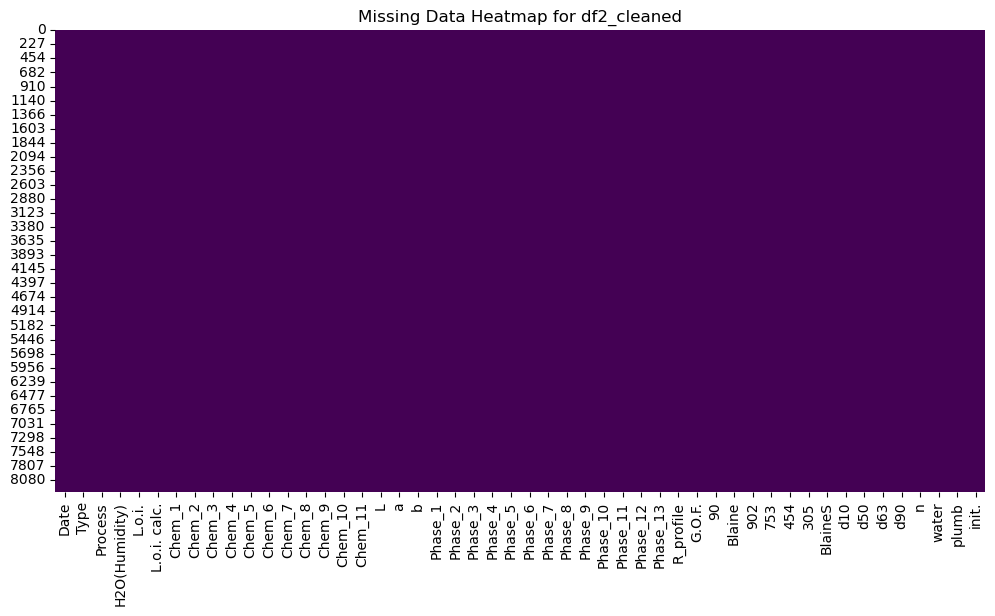

In [ ]:
# Step 1: Drop specified columns
# Define column groups
chem_info_cols   = ["Chem_12", "Chem_Sum", "Phase_Ratio_3_1", "Chem_Ratio_2_7"]
leakage_cols     = ["end", "6h"]
zero_var_cols    = ["Alum"]

# Combine all columns to drop
cols_to_drop = chem_info_cols + leakage_cols + zero_var_cols

# Initial shape
initial_shape = df2_cleaned.shape

# Drop columns
df2_cleaned = df2_cleaned.drop(columns=cols_to_drop, errors="ignore")
print(f"🗑️ Dropped columns: {cols_to_drop}")

# Summary: NaNs per column
nan_summary = df2_cleaned.isnull().sum()
nan_percent = 100 * nan_summary / len(df2_cleaned)

nan_report = pd.DataFrame({
    "Missing Count": nan_summary,
    "Missing %": nan_percent
}).sort_values(by="Missing Count", ascending=False)

print("\n📊 Missing value summary (before row removal):")
display(nan_report[nan_report["Missing Count"] > 0])

# Drop rows with any NaNs
df2_cleaned = df2_cleaned.dropna()

# Final shape and summary
final_shape = df2_cleaned.shape
rows_lost = initial_shape[0] - final_shape[0]
percent_lost = 100 * rows_lost / initial_shape[0]

print(f"\n✅ Shape before: {initial_shape}")
print(f"✅ Shape after:  {final_shape}")
print(f"📉 Rows removed: {rows_lost} ({percent_lost:.2f}% loss)")


analyze_missing_values(df2_cleaned, "df2_cleaned")

📐 Chem sum bounds: [99.29, 100.29]
📐 Phase sum bounds: [99.49, 100.49]

✅ Raw data cleaning complete:
   Initial shape: (7429, 50)
Type
ISTRA 40        2065
ISTRA 50        1186
ISTRA 45         948
Lumnite SG       922
ISTRA 50 5.0     789
CEMFAST          466
Lumnite SG5      346
Istra 45 ND      263
Bricocem         131
Lumnite MG4       75
Bricocem +        54
Ostali            51
ECO2Flex 50       36
Lumnite MG        17
ISTRAflex         14
Lumnite           12
Istra 45 mix       9
B50                9
Refcon MG          9
ECO2Flex SCM       6
Lumnite SG6        6
Refcon             5
I40mix             3
Istra Ultra        3
ECO2Flex           2
Caluflex           2
Name: count, dtype: int64
   Final shape:   (6601, 49)
Type
ISTRA 40        1904
ISTRA 50        1034
ISTRA 45         884
Lumnite SG       840
ISTRA 50 5.0     725
CEMFAST          422
Lumnite SG5      306
Istra 45 ND      239
Lumnite MG4       69
ECO2Flex 50       34
Ostali            34
Bricocem          26
Lumnit

,Rows Removed,% of Total
Chem_Sum_Outside_0.5%,813,10.943599
Phase_Sum_Outside_0.5%,6,0.080765
plumb,6,0.080765
d63,1,0.013461
d90,1,0.013461
902,1,0.013461



Dataset Info for df_clean_raw:
<class 'pandas.core.frame.DataFrame'>
Index: 6601 entries, 0 to 8320
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6601 non-null   datetime64[ns]
 1   Type           6601 non-null   object        
 2   Process        6601 non-null   object        
 3   H2O(Humidity)  6601 non-null   float64       
 4   Chem_1         6601 non-null   float64       
 5   Chem_2         6601 non-null   float64       
 6   Chem_3         6601 non-null   float64       
 7   Chem_4         6601 non-null   float64       
 8   Chem_5         6601 non-null   float64       
 9   Chem_6         6601 non-null   float64       
 10  Chem_7         6601 non-null   float64       
 11  Chem_8         6601 non-null   float64       
 12  Chem_9         6601 non-null   float64       
 13  Chem_10        6601 non-null   float64       
 14  Chem_11        6601 non-null   float64       

,Missing Values,Empty Strings,Total Missing,Percentage Missing


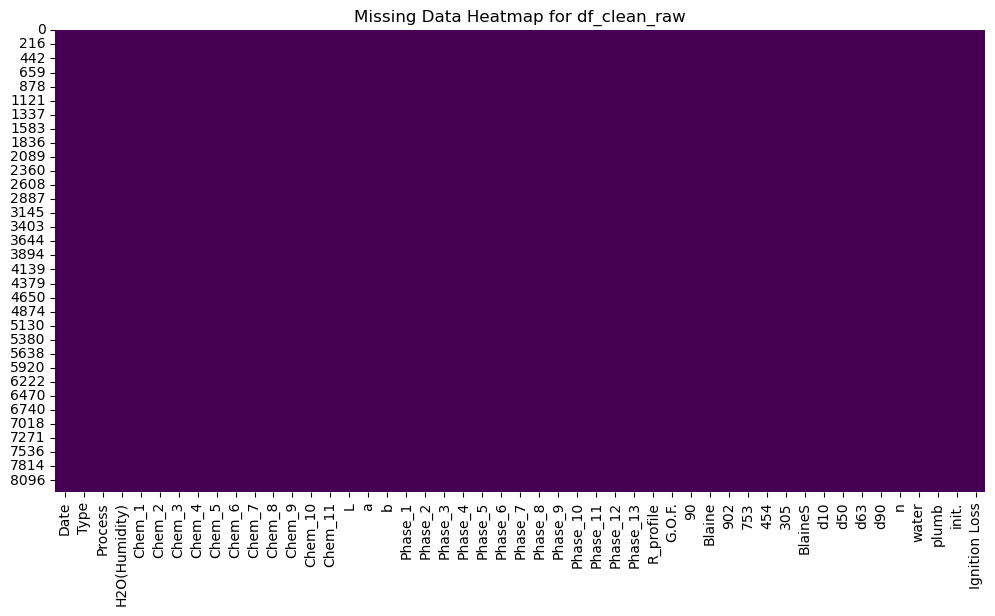

In [ ]:
# Copy original to avoid mutation
df_check = df2_cleaned.copy()
initial_shape = df_check.shape

# Step 1: Create "Ignition Loss" column
df_check["Ignition Loss"] = df_check.apply(
    lambda row: row["L.o.i."] if row["L.o.i."] >= 0 else (
        row["L.o.i. calc."] if row["L.o.i. calc."] >= 0 else 0
    ),
    axis=1
)
df_check.drop(columns=["L.o.i.", "L.o.i. calc."], inplace=True)

# Step 2: Initialize tracking
valid_mask = pd.Series(True, index=df_check.index)
removal_report = {}

def track_removal(df, mask, col, condition):
    """Update mask and record how many rows would be removed by a condition."""
    condition_mask = condition
    to_remove = (~condition_mask & mask)
    if to_remove.any():
        removal_report[col] = to_remove.sum()
    return mask & condition_mask

# Step 3: Apply rules

# 1. H2O
valid_mask = track_removal(df_check, valid_mask, "H2O(Humidity)", df_check["H2O(Humidity)"].between(0, 100))

# 2. Chem_1 to Chem_11 — validate individual values
chem_cols = [f"Chem_{i}" for i in range(1, 12)]
for col in chem_cols:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col].between(0, 100))

# ✅ Check sum of Chem_1–11 within ±0.5% of mean
chem_mean_sum = df_check.loc[valid_mask, chem_cols].sum(axis=1).mean()
chem_bounds = (0.995 * chem_mean_sum, 1.005 * chem_mean_sum)
print(f"📐 Chem sum bounds: [{chem_bounds[0]:.2f}, {chem_bounds[1]:.2f}]")

chem_sum_mask = df_check[chem_cols].sum(axis=1).between(*chem_bounds)
removed_chem_sum = (~chem_sum_mask & valid_mask).sum()
if removed_chem_sum > 0:
    removal_report["Chem_Sum_Outside_0.5%"] = removed_chem_sum
valid_mask &= chem_sum_mask

# 3. Phase_1 to Phase_13 — validate individual values
phase_cols = [f"Phase_{i}" for i in range(1, 14)]
for col in phase_cols:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col].between(0, 100))

# ✅ Check sum of Phase_1–13 within ±0.5% of mean
phase_mean_sum = df_check.loc[valid_mask, phase_cols].sum(axis=1).mean()
phase_bounds = (0.995 * phase_mean_sum, 1.005 * phase_mean_sum)
print(f"📐 Phase sum bounds: [{phase_bounds[0]:.2f}, {phase_bounds[1]:.2f}]")

phase_sum_mask = df_check[phase_cols].sum(axis=1).between(*phase_bounds)
removed_phase_sum = (~phase_sum_mask & valid_mask).sum()
if removed_phase_sum > 0:
    removal_report["Phase_Sum_Outside_0.5%"] = removed_phase_sum
valid_mask &= phase_sum_mask



# 4. L in [0,100], a/b in [-128,128]
valid_mask = track_removal(df_check, valid_mask, "L", df_check["L"].between(0, 100))
valid_mask = track_removal(df_check, valid_mask, "a", df_check["a"].between(-128, 128))
valid_mask = track_removal(df_check, valid_mask, "b", df_check["b"].between(-128, 128))

# 5. R_profile and G.O.F.
for col in ["R_profile", "G.O.F."]:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col] > 0)

# 6. Blaine
for col in ["Blaine", "BlaineS"]:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col] >= 0)

# 7. Particle size filters
for col in ["d10", "d50", "d63", "d90", "902", "753", "454", "305"]:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col].between(0, 100))

# 8. Workability / setting
for col in ["water", "plumb", "init."]:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col] > 0)

# 9. Slope exponent (n) and 90 filtering
for col in ["n", "90"]:
    valid_mask = track_removal(df_check, valid_mask, col, df_check[col] >= 0)

# Step 4: Filter rows and report
df_clean_raw = df_check[valid_mask].copy()
final_shape = df_clean_raw.shape
rows_removed = initial_shape[0] - final_shape[0]
percent_removed = 100 * rows_removed / initial_shape[0]

# Report
removal_df = pd.DataFrame.from_dict(removal_report, orient='index', columns=["Rows Removed"])
removal_df["% of Total"] = 100 * removal_df["Rows Removed"] / initial_shape[0]
removal_df.sort_values("Rows Removed", ascending=False, inplace=True)

print(f"\n✅ Raw data cleaning complete:")
print(f"   Initial shape: {initial_shape}")
print(df_check['Type'].value_counts())
print(f"   Final shape:   {final_shape}")
print(df_clean_raw['Type'].value_counts())
print(f"   Total rows removed: {rows_removed} ({percent_removed:.2f}%)")
print("\n📊 Breakdown by column:")
display(removal_df)
analyze_missing_values(df_clean_raw, "df_clean_raw")

📊 Value Counts After Filtering:
Type
ISTRA 40        1904
ISTRA 50        1034
ISTRA 45         884
Lumnite SG       840
ISTRA 50 5.0     725
CEMFAST          422
Lumnite SG5      306
Name: count, dtype: int64

✅ Filtered dataset shape: (6115, 49)

Dataset Info for df2_filtered:
<class 'pandas.core.frame.DataFrame'>
Index: 6115 entries, 0 to 8320
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6115 non-null   datetime64[ns]
 1   Type           6115 non-null   object        
 2   Process        6115 non-null   object        
 3   H2O(Humidity)  6115 non-null   float64       
 4   Chem_1         6115 non-null   float64       
 5   Chem_2         6115 non-null   float64       
 6   Chem_3         6115 non-null   float64       
 7   Chem_4         6115 non-null   float64       
 8   Chem_5         6115 non-null   float64       
 9   Chem_6         6115 non-null   float64       
 10  C

,Missing Values,Empty Strings,Total Missing,Percentage Missing


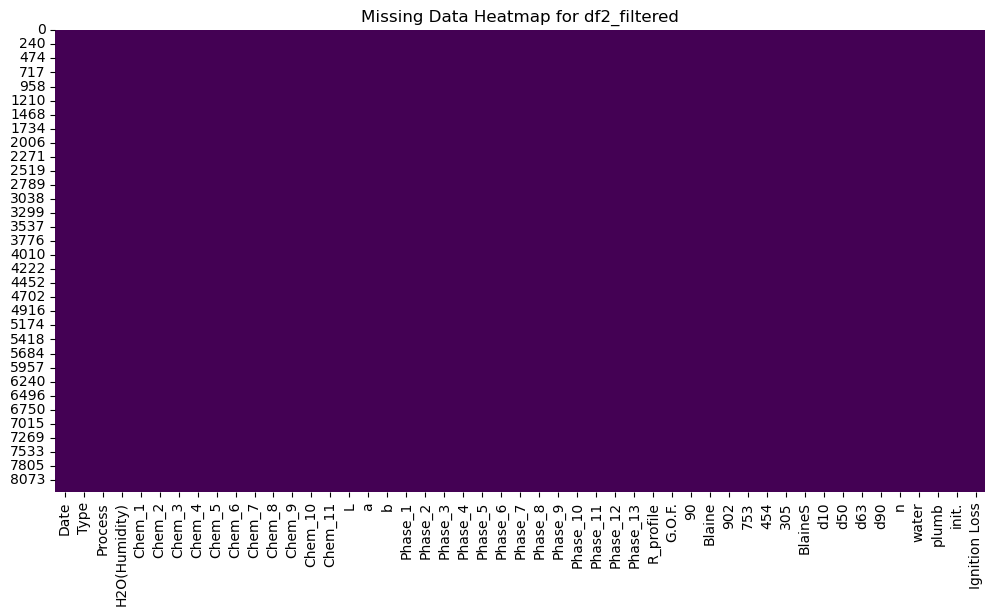

In [ ]:
# Define the cement types to keep
types_to_keep = [
    "ISTRA 40",
    "ISTRA 50",
    "Lumnite SG",
    "ISTRA 45",
    "ISTRA 50 5.0",
    "Lumnite SG5",
    "CEMFAST"
]

# Filter the DataFrame
df2_filtered = df_clean_raw[df_clean_raw["Type"].isin(types_to_keep)].copy()

# Show counts to confirm
print("📊 Value Counts After Filtering:")
print(df2_filtered["Type"].value_counts())

# Optional: show new shape
print(f"\n✅ Filtered dataset shape: {df2_filtered.shape}")

analyze_missing_values(df2_filtered, "df2_filtered")


In [ ]:
import numpy as np
import pandas as pd

# Define compositional groups
chem_cols = [f"Chem_{i}" for i in range(1, 12)]
phase_cols = [f"Phase_{i}" for i in range(1, 14)]

# Output dictionary
cement_dfs_with_ilr = {}

# Loop through each cement type
for cement_type, df in cement_dfs.items():
    df_transformed = df.copy()

    print(f"\n🔁 ILR transforming: {cement_type} ({len(df)} rows)")

    # --- Chem ILR ---
    print(f"🧪 Chem columns used: {chem_cols}")
    chem_data = df[chem_cols].replace(0, 1e-6)
    chem_sum = chem_data.sum(axis=1)
    chem_closure = chem_data.div(chem_sum, axis=0).to_numpy()
    ilr_chem = ilr_transform(chem_closure)
    ilr_chem_df = pd.DataFrame(ilr_chem, columns=[f"Chem_ilr_{i+1}" for i in range(ilr_chem.shape[1])], index=df.index)
    df_transformed = pd.concat([df_transformed, ilr_chem_df], axis=1)

    # --- Phase ILR ---
    print(f"🧪 Phase columns used: {phase_cols}")
    phase_data = df[phase_cols].replace(0, 1e-6)
    phase_sum = phase_data.sum(axis=1)
    phase_closure = phase_data.div(phase_sum, axis=0).to_numpy()
    ilr_phase = ilr_transform(phase_closure)
    ilr_phase_df = pd.DataFrame(ilr_phase, columns=[f"Phase_ilr_{i+1}" for i in range(ilr_phase.shape[1])], index=df.index)
    df_transformed = pd.concat([df_transformed, ilr_phase_df], axis=1)

    # --- Show result ---
    print(f"📌 Transformed DataFrame preview for: {cement_type}")
    display(df_transformed.head())

    # Save result
    cement_dfs_with_ilr[cement_type] = df_transformed

print("\n✅ All cement types processed. Transformed DataFrames stored in 'cement_dfs_with_ilr'.")

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 0: Stratified split into train/val/test by 'Type'
cement_xy_split = {}

TARGET_COL = "init."  # Define the target

for cement_type, df in cement_dfs_with_ilr.items():
    # First split: train (80%) / test (20%), stratified by Type
    df_trainval, df_test = train_test_split(
        df, test_size=0.2, stratify=df["Type"], random_state=42
    )

    # Second split: train (85% of trainval) / val (15% of trainval), stratified
    df_train, df_val = train_test_split(
        df_trainval, test_size=0.15, stratify=df_trainval["Type"], random_state=42
    )

    cement_xy_split[cement_type] = {
        "X_train": df_train.drop(columns=[TARGET_COL]).reset_index(drop=True),
        "y_train": df_train[TARGET_COL].reset_index(drop=True),
        "X_val": df_val.drop(columns=[TARGET_COL]).reset_index(drop=True),
        "y_val": df_val[TARGET_COL].reset_index(drop=True),
        "X_test": df_test.drop(columns=[TARGET_COL]).reset_index(drop=True),
        "y_test": df_test[TARGET_COL].reset_index(drop=True),
    }

# Step 1: Define excluded columns
excluded_cols = [
    "Date", "Type", "Process",  # categorical
    TARGET_COL                  # explicitly exclude the target
]

# Step 2: Collect column names
example_df = next(iter(cement_dfs_with_ilr.values()))
all_columns = list(example_df.columns)

# ILR-transformed features
ilr_chem_cols = [col for col in all_columns if col.startswith("Chem_ilr_")]
ilr_phase_cols = [col for col in all_columns if col.startswith("Phase_ilr_")]

# Other numeric features to consider (not excluded)
numeric_other_cols = [
    "R_profile", "G.O.F.", "water", "plumb", "n",
    "Blaine", "BlaineS", "d10", "d50", "d63", "d90",
    "902", "753", "454", "305", "90", "Ignition Loss", "H2O(Humidity)",
    "L", "a", "b"
]

# Filter to include only available and valid numeric features
columns_to_check = [
    col for col in ilr_chem_cols + numeric_other_cols
    if col not in excluded_cols and col in all_columns
]

# Combine for total column count
all_cols_for_filtering = columns_to_check + ilr_phase_cols
n_cols = len(all_cols_for_filtering)

# Step 3: Define thresholds
max_retention = 0.9
intended_outlier_frac = (1 - max_retention) / n_cols
only_threshold = 1 - intended_outlier_frac
thresholds_array = list(np.linspace(1 - intended_outlier_frac, 1.0, 4))

# Step 4: Print summary
print(f"\n✅ ILR chemical columns:\n{ilr_chem_cols}")
print(f"\n✅ ILR phase columns:\n{ilr_phase_cols}")
print(f"\n✅ Numeric columns checked:\n{numeric_other_cols}")
print(f"\n✅ Final columns to check (non-phase):\n{columns_to_check}")
print(f"\n✅ Total features filtered: {n_cols}")
print(f"🧮 only_threshold per feature: {only_threshold:.5f}")
print(f"📈 thresholds array: {thresholds_array}")




✅ ILR chemical columns:
['Chem_ilr_1', 'Chem_ilr_2', 'Chem_ilr_3', 'Chem_ilr_4', 'Chem_ilr_5', 'Chem_ilr_6', 'Chem_ilr_7', 'Chem_ilr_8', 'Chem_ilr_9', 'Chem_ilr_10']

✅ ILR phase columns:
['Phase_ilr_1', 'Phase_ilr_2', 'Phase_ilr_3', 'Phase_ilr_4', 'Phase_ilr_5', 'Phase_ilr_6', 'Phase_ilr_7', 'Phase_ilr_8', 'Phase_ilr_9', 'Phase_ilr_10', 'Phase_ilr_11', 'Phase_ilr_12']

✅ Numeric columns checked:
['R_profile', 'G.O.F.', 'water', 'plumb', 'n', 'Blaine', 'BlaineS', 'd10', 'd50', 'd63', 'd90', '902', '753', '454', '305', '90', 'Ignition Loss', 'H2O(Humidity)', 'L', 'a', 'b']

✅ Final columns to check (non-phase):
['Chem_ilr_1', 'Chem_ilr_2', 'Chem_ilr_3', 'Chem_ilr_4', 'Chem_ilr_5', 'Chem_ilr_6', 'Chem_ilr_7', 'Chem_ilr_8', 'Chem_ilr_9', 'Chem_ilr_10', 'R_profile', 'G.O.F.', 'water', 'plumb', 'n', 'Blaine', 'BlaineS', 'd10', 'd50', 'd63', 'd90', '902', '753', '454', '305', '90', 'Ignition Loss', 'H2O(Humidity)', 'L', 'a', 'b']

✅ Total features filtered: 43
🧮 only_threshold per feature: 

In [ ]:
# Step 5: Apply univariate filtering only on X_train
cement_train_filtered = {}

for cement_type, split in cement_xy_split.items():
    xtrain = split["X_train"]

    filtered = clean_univariate_bootstrap_density_weighted(
        dataframes_dict={cement_type: xtrain},
        ilr_columns=columns_to_check,
        composition_columns=[],
        phase_columns=ilr_phase_cols,
        thresholds=thresholds_array,
        n_bins=1000,
        max_memory_gb=12,
        dtype="float64",
        verbose=False,
        bootstrap="auto",
        n_bootstrap="auto",
        only_threshold=only_threshold,
        pect_prominence=0.05,
        weight=None,
        filtering=False
    )

    cement_train_filtered[cement_type] = {
        "X_train": filtered[cement_type],
        "y_train": split["y_train"],
        "X_test": split["X_test"],
        "y_test": split["y_test"]
    }

print("Finished!")

✅ ISTRA 40: 1523 → 1523 rows remaining after filtering.
⏱️ Total time elapsed: 4.79 seconds.
✅ Lumnite SG: 672 → 672 rows remaining after filtering.
⏱️ Total time elapsed: 11.99 seconds.
✅ ISTRA 50 5.0: 580 → 580 rows remaining after filtering.
⏱️ Total time elapsed: 12.15 seconds.
✅ ISTRA 45: 707 → 707 rows remaining after filtering.
⏱️ Total time elapsed: 12.56 seconds.
✅ ISTRA 50: 827 → 827 rows remaining after filtering.
⏱️ Total time elapsed: 11.24 seconds.
✅ CEMFAST: 337 → 337 rows remaining after filtering.
⏱️ Total time elapsed: 12.88 seconds.
✅ Lumnite SG5: 244 → 244 rows remaining after filtering.
⏱️ Total time elapsed: 11.22 seconds.
Finished!


In [ ]:
# Dictionary to store filtering stats
filtered_counts = {}

for cement_type, splits in cement_train_filtered.items():
    df_train = splits["X_train"]

    # Identify all *_cluster columns
    cluster_cols = [col for col in df_train.columns if col.endswith("_cluster")]

    if not cluster_cols:
        continue  # Skip if no cluster labels present

    # Build a mask: any row with -1 in any of the *_cluster columns
    mask_any_filtered = df_train[cluster_cols].eq(-1).any(axis=1)

    # Count how many rows would have been filtered
    n_total = df_train.shape[0]
    n_filtered = mask_any_filtered.sum()
    pct_filtered = 100 * n_filtered / n_total if n_total > 0 else 0

    filtered_counts[cement_type] = {
        "Total Rows (Train)": n_total,
        "Would-Be Filtered": n_filtered,
        "% Filtered": round(pct_filtered, 2)
    }

# Convert to DataFrame for summary
df_filter_report = pd.DataFrame.from_dict(filtered_counts, orient="index")
display(df_filter_report)



,Total Rows (Train),Would-Be Filtered,% Filtered
ISTRA 40,1523,72,4.73
Lumnite SG,672,19,2.83
ISTRA 50 5.0,580,21,3.62
ISTRA 45,707,25,3.54
ISTRA 50,827,21,2.54
CEMFAST,337,0,0.00
Lumnite SG5,244,0,0.00


In [ ]:
# === Step 1: Define excluded columns ===
excluded_cols = ["Date", "Type", "Process"]

# === Step 2: Collect column names from an example ===
example_df = cement_train_filtered[first_key]["X_train"]
all_columns = list(example_df.columns)

# ILR-transformed features
ilr_chem_cols = [col for col in all_columns if col.startswith("Chem_ilr_") and not col.endswith("_cluster")]
ilr_phase_cols = [col for col in all_columns if col.startswith("Phase_ilr_") and not col.endswith("_cluster")]

# Cluster label columns (to exclude from filtering)
cluster_cols = [col for col in all_columns if col.endswith("_cluster")]
excluded_cols += cluster_cols

# Other numeric features to check
numeric_other_cols = [
    "R_profile", "G.O.F.", "water", "plumb", "init.", "n",
    "Blaine", "BlaineS", "d10", "d50", "d63", "d90",
    "902", "753", "454", "305", "90", "Ignition Loss", "H2O(Humidity)",
    "L", "a", "b"
]

# === Step 3: Final columns for Isolation Forest filtering ===
columns_to_check = [
    col for col in ilr_chem_cols + numeric_other_cols
    if col not in excluded_cols and col in all_columns
]
all_cols_for_filtering = columns_to_check + ilr_phase_cols
n_cols = len(all_cols_for_filtering)

print(f"\n🔎 Total columns used for IForest filtering: {n_cols}")
print(all_cols_for_filtering)

# === Step 4: Show filtering usage summary per cement type ===
for cement_type, data_split in cement_train_filtered.items():
    df_train = data_split["X_train"]
    cols_in_df = df_train.columns.tolist()
    used_cols = [col for col in cols_in_df if col in all_cols_for_filtering]
    unused_cols = [col for col in cols_in_df if col not in all_cols_for_filtering]

    print(f"\n🧱 Cement type: {cement_type}")
    print(f"✅ Used for IForest ({len(used_cols)}): {used_cols}")
    print(f"🚫 Not used in IForest ({len(unused_cols)}): {unused_cols}")

# === Step 5: Apply Isolation Forest to X_train only ===
cement_train_iforest_flagged = {}

for cement_type, split in cement_train_filtered.items():
    df_train_X = split["X_train"]
    df_val_X = split["X_val"]
    df_test_X = split["X_test"]
    df_train_y = split["y_train"]
    df_val_y = split["y_val"]
    df_test_y = split["y_test"]

    # Apply Isolation Forest on training features
    filtered_dict = clean_multivariate_outliers_iforest_set(
        dataframes_dict={cement_type: df_train_X},
        columns_to_check=all_cols_for_filtering,
        contamination_values=None,
        outlier_threshold=15,
        filtering=False,
        verbose=True
    )

    # Final structure includes all splits
    cement_train_iforest_flagged[cement_type] = {
        "X_train": filtered_dict[cement_type],
        "X_val": df_val_X,
        "X_test": df_test_X,
        "y_train": df_train_y,
        "y_val": df_val_y,
        "y_test": df_test_y
    }


In [ ]:
cement_dfs_final_filter_or = {}
cement_dfs_final_filter_and = {}

for cement_type, split in cement_train_iforest_flagged.items():
    X_train = split["X_train"]
    y_train = split["y_train"]
    X_val = split["X_val"]
    y_val = split["y_val"]
    X_test = split["X_test"]
    y_test = split["y_test"]

    # Identify _cluster columns
    cluster_cols = [col for col in X_train.columns if col.endswith("_cluster")]

    # Build masks
    univariate_mask = X_train[cluster_cols].eq(-1).any(axis=1)
    multivariate_mask = X_train["Outlier_IForest"] == True

    # OR removal mask: flagged by either
    or_mask = univariate_mask | multivariate_mask

    # AND removal mask: flagged by both
    and_mask = univariate_mask & multivariate_mask

    # OR logic filtered set
    X_or = X_train[~or_mask].copy()
    y_or = y_train.loc[X_or.index].copy()

    cement_dfs_final_filter_or[cement_type] = {
        "X_train": X_or,
        "y_train": y_or,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test
    }

    # AND logic filtered set
    X_and = X_train[~and_mask].copy()
    y_and = y_train.loc[X_and.index].copy()

    cement_dfs_final_filter_and[cement_type] = {
        "X_train": X_and,
        "y_train": y_and,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test
    }

    # Reporting
    print(f"\n🧱 Cement: {cement_type}")
    print(f"   ➤ OR Logic → Before: {X_train.shape[0]}, After: {X_or.shape[0]} (Removed: {X_train.shape[0] - X_or.shape[0]} | {100 * (X_train.shape[0] - X_or.shape[0]) / X_train.shape[0]:.2f}%)")
    print(f"   ➤ AND Logic → Before: {X_train.shape[0]}, After: {X_and.shape[0]} (Removed: {X_train.shape[0] - X_and.shape[0]} | {100 * (X_train.shape[0] - X_and.shape[0]) / X_train.shape[0]:.2f}%)")

# Optional preview
first_key = list(cement_dfs_final_filter_or.keys())[0]
print(f"\n📄 Preview (OR mask) for cement type: {first_key}")
display(cement_dfs_final_filter_or[first_key]["X_train"].head())

print(f"\n📄 Preview (AND mask) for cement type: {first_key}")
display(cement_dfs_final_filter_and[first_key]["X_train"].head())


In [ ]:
def mahalanobis_qq_plot(X, title):
    X_clean = X.dropna().values
    cov = MinCovDet().fit(X_clean)
    dists = cov.mahalanobis(X_clean)
    quantiles = chi2.ppf((np.arange(1, len(dists)+1) - 0.5) / len(dists), df=X.shape[1])
    dists_sorted = np.sort(dists)

    plt.figure(figsize=(6, 6))
    plt.plot(quantiles, dists_sorted, 'o', label='Empirical')
    plt.plot([quantiles.min(), quantiles.max()],
             [quantiles.min(), quantiles.max()],
             'r--', label='Ideal')
    plt.xlabel("Theoretical Quantiles (Chi²)")
    plt.ylabel("Empirical Mahalanobis Distance")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def umap_plot(df, cols, title):
    reducer = umap.UMAP(random_state=42)
    emb = reducer.fit_transform(df[cols].dropna())
    augmented = df.loc[df[cols].dropna().index, "Augmented"] if "Augmented" in df.columns else 0

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=augmented, palette="coolwarm", alpha=0.6)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Augmented", loc="best")
    plt.tight_layout()
    plt.show()

def pearson_heatmap(df, cols, title):
    corr = df[cols].corr(method="pearson")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, skew, kurtosis, chi2, kstest
from sklearn.covariance import MinCovDet

# --- Normality Stat Calculation ---
def compute_mahalanobis(X):
    X = X.dropna().values
    robust_cov = MinCovDet().fit(X)
    return robust_cov.mahalanobis(X)

def assess_multivariate_normality(mahal_dists, df):
    df_chi2 = df.shape[1]
    stat, p_value = kstest(mahal_dists, chi2(df_chi2).cdf)
    return stat, p_value

def print_normality_stats(X, label):
    print(f"\n📊 Normality Metrics: {label}")
    stats = []
    for col in X.columns:
        values = X[col].dropna()
        if len(values) < 3:
            continue
        shapiro_p = shapiro(values)[1]
        stats.append((col, shapiro_p, skew(values), kurtosis(values)))

    df_stats = pd.DataFrame(stats, columns=["Feature", "Shapiro_p", "Skewness", "Kurtosis"])
    df_stats.set_index("Feature", inplace=True)

    mean_shapiro = df_stats["Shapiro_p"].mean()
    median_shapiro = df_stats["Shapiro_p"].median()
    mean_skew = df_stats["Skewness"].mean()
    median_skew = df_stats["Skewness"].median()
    mean_kurt = df_stats["Kurtosis"].mean()
    median_kurt = df_stats["Kurtosis"].median()

    mahal_dists = compute_mahalanobis(X)
    ks_stat, ks_p = assess_multivariate_normality(mahal_dists, X)
    mean_mahal = np.mean(mahal_dists)
    median_mahal = np.median(mahal_dists)

    print(f"\n✅ Summary:")
    print(f"   ➤ Mean Shapiro p-value: {mean_shapiro:.4f} | Median: {median_shapiro:.4f}")
    print(f"   ➤ Mean Skewness: {mean_skew:.4f} | Median: {median_skew:.4f}")
    print(f"   ➤ Mean Kurtosis: {mean_kurt:.4f} | Median: {median_kurt:.4f}")
    print(f"   ➤ Mahalanobis KS p-value: {ks_p:.4f}")
    print(f"   ➤ Mean Mahalanobis distance: {mean_mahal:.4f} | Median: {median_mahal:.4f}")

    return {
        "mean_shapiro": mean_shapiro,
        "median_shapiro": median_shapiro,
        "ks_p": ks_p,
        "mean_mahalanobis": mean_mahal,
        "median_mahalanobis": median_mahal,
        "mean_skew": mean_skew,
        "median_skew": median_skew,
        "mean_kurtosis": mean_kurt,
        "median_kurtosis": median_kurt,
    }

# --- Utility to cleanly rename stats with prefix ---
def rename_metrics(stats_dict, prefix):
    name_map = {
        "mean_shapiro": "Mean Shapiro",
        "median_shapiro": "Median Shapiro",
        "ks_p": "KS p",
        "mean_mahalanobis": "Mean Mahalanobis",
        "median_mahalanobis": "Median Mahalanobis",
        "mean_skew": "Mean Skew",
        "median_skew": "Median Skew",
        "mean_kurtosis": "Mean Kurtosis",
        "median_kurtosis": "Median Kurtosis"
    }
    return {f"{prefix} {name_map[k]}": v for k, v in stats_dict.items() if k in name_map}

# --- Collect all results ---
final_summary = []

for cement_type in cement_xy_split.keys():
    X_raw = cement_xy_split[cement_type]["X_train"]
    X_and = cement_dfs_final_filter_and[cement_type]["X_train"]
    X_or = cement_dfs_final_filter_or[cement_type]["X_train"]
    used_cols = [col for col in all_cols_for_filtering if col in X_raw.columns]

    print(f"\n🧱 Cement Type: {cement_type}")
    print(f"🔎 Columns used: {len(used_cols)}")

    stats_raw = print_normality_stats(X_raw[used_cols], f"{cement_type} — Raw (Unfiltered)")
    stats_and = print_normality_stats(X_and[used_cols], f"{cement_type} — Filtered (AND)")
    stats_or = print_normality_stats(X_or[used_cols], f"{cement_type} — Filtered (OR)")

    row = {"Cement Type": cement_type}
    row.update(rename_metrics(stats_raw, "Raw"))
    row.update(rename_metrics(stats_and, "AND"))
    row.update(rename_metrics(stats_or, "OR"))
    final_summary.append(row)

# --- Create DataFrame
df_summary = pd.DataFrame(final_summary)

# --- Compute delta columns
metrics = [
    "Mean Shapiro", "Median Shapiro", "KS p",
    "Mean Mahalanobis", "Median Mahalanobis",
    "Mean Skew", "Median Skew", "Mean Kurtosis", "Median Kurtosis"
]

for metric in metrics:
    df_summary[f"Δ {metric} (AND - Raw)"] = df_summary[f"AND {metric}"] - df_summary[f"Raw {metric}"]
    df_summary[f"Δ {metric} (OR - Raw)"] = df_summary[f"OR {metric}"] - df_summary[f"Raw {metric}"]

# --- Display final result
df_summary = df_summary.sort_values(by="Δ Mean Shapiro (AND - Raw)", ascending=False)
display(df_summary)


In [ ]:
import numpy as np
import pandas as pd

# Assuming df_summary already exists and has full column names
# e.g., "Raw Mean Shapiro", "AND Mean Shapiro", etc.

# Define metric configs
raw_weights = {
    "mean_shapiro":     1.0,
    "median_shapiro":   1.5,
    "ks_p":             1.0,
    "mean_mahalanobis": 1.0,
    "median_mahalanobis": 1.5,
    "mean_skew":        0.5,
    "median_skew":      0.25,
    "mean_kurtosis":    0.5,
    "median_kurtosis":  0.25
}

thresholds = {
    "mean_shapiro":     1.0,
    "median_shapiro":   1.0,
    "ks_p":             1.5,
    "mean_mahalanobis": 0.5,
    "median_mahalanobis": 0.5,
    "mean_skew":        5.0,
    "median_skew":      5.0,
    "mean_kurtosis":    5.0,
    "median_kurtosis":  5.0
}

higher_is_better = {
    "mean_shapiro": True,
    "median_shapiro": True,
    "ks_p": True,
    "mean_mahalanobis": False,
    "median_mahalanobis": False,
    "mean_skew": False,
    "median_skew": False,
    "mean_kurtosis": False,
    "median_kurtosis": False
}

# Normalize weights
total_weight = sum(raw_weights.values())
weights = {k: v / total_weight for k, v in raw_weights.items()}

# Mapping to full column labels in df_summary
label_map = {
    "mean_shapiro": "Mean Shapiro",
    "median_shapiro": "Median Shapiro",
    "ks_p": "KS p",
    "mean_mahalanobis": "Mean Mahalanobis",
    "median_mahalanobis": "Median Mahalanobis",
    "mean_skew": "Mean Skew",
    "median_skew": "Median Skew",
    "mean_kurtosis": "Mean Kurtosis",
    "median_kurtosis": "Median Kurtosis"
}

# Store results
best_versions = {}
cement_dfs_final_filter = {}

for cement in df_summary["Cement Type"].unique():
    row = df_summary[df_summary["Cement Type"] == cement].iloc[0]
    version_scores = {"RAW": 0.0, "AND": 0.0, "OR": 0.0}

    for metric_key in weights:
        label = label_map[metric_key]
        raw_col = f"Raw {label}"

        for logic in ["AND", "OR"]:
            logic_col = f"{logic} {label}"
            raw_val = row[raw_col]
            logic_val = row[logic_col]

            if abs(raw_val) < 1e-8:
                continue  # avoid division by zero

            delta = logic_val - raw_val
            pct_change = (delta / abs(raw_val)) * 100
            meets_threshold = abs(pct_change) >= thresholds[metric_key]

            if not meets_threshold:
                continue

            # Add or subtract from score depending on whether it's better or worse
            if (higher_is_better[metric_key] and delta > 0) or (not higher_is_better[metric_key] and delta < 0):
                version_scores[logic] += weights[metric_key]
            else:
                version_scores[logic] -= weights[metric_key]

    # Pick version with highest score
    best_version = max(version_scores, key=version_scores.get)
    best_versions[cement] = {
        "Best": best_version,
        "Score AND": version_scores["AND"],
        "Score OR": version_scores["OR"],
        "Score RAW": version_scores["RAW"]
    }

    # Save the best dataset into final filter
    if best_version == "RAW":
        cement_dfs_final_filter[cement] = cement_xy_split[cement]
    elif best_version == "AND":
        cement_dfs_final_filter[cement] = cement_dfs_final_filter_and[cement]
    elif best_version == "OR":
        cement_dfs_final_filter[cement] = cement_dfs_final_filter_or[cement]

    print(f"📦 Saved {best_version} for {cement}")

# Show results
df_best = pd.DataFrame.from_dict(best_versions, orient="index")
df_best.index.name = "Cement Type"
df_best.reset_index(inplace=True)
display(df_best)


📦 Saved AND for ISTRA 50
📦 Saved OR for ISTRA 45
📦 Saved OR for ISTRA 50 5.0
📦 Saved OR for ISTRA 40
📦 Saved OR for Lumnite SG
📦 Saved RAW for CEMFAST
📦 Saved OR for Lumnite SG5


,Cement Type,Best,Score AND,Score OR,Score RAW
0,ISTRA 50,AND,0.500000,0.466667,0.0
1,ISTRA 45,OR,0.200000,0.666667,0.0
2,ISTRA 50 5.0,OR,0.433333,0.666667,0.0
3,ISTRA 40,OR,-0.100000,0.533333,0.0
4,Lumnite SG,OR,0.333333,0.666667,0.0
5,CEMFAST,RAW,-0.066667,-0.200000,0.0
6,Lumnite SG5,OR,0.333333,0.400000,0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import warnings

def ilr_inv(ilr_array, scale_factors=None):
    from math import sqrt
    n_samples, D_minus_1 = ilr_array.shape
    D = D_minus_1 + 1
    comp_array = np.zeros((n_samples, D))

    for i in range(n_samples):
        y = ilr_array[i]
        z = np.zeros(D)
        z[-1] = 1.0

        try:
            for j in reversed(range(D - 1)):
                coef = sqrt((j + 1) / (j + 2))
                exp_val = y[j] / coef
                if not np.isfinite(exp_val):
                    print(f"⚠️ ILR inversion warning: non-finite exponent y[{j}] / coef = {y[j]} / {coef}")
                    raise ValueError("Non-finite exponent in ILR inversion")

                gmean = np.exp(np.mean(np.log(z[j+1:])))
                z[j] = gmean * np.exp(exp_val)

            total = scale_factors[i] if scale_factors is not None else 100.0
            denominator = np.sum(z)
            if denominator == 0 or not np.isfinite(denominator):
                print(f"⚠️ ILR inversion warning: denominator invalid (sum(z) = {denominator})")
                raise ValueError("Invalid denominator in ILR inversion")

            comp_array[i] = total * z / denominator

        except Exception as e:
            print(f"❌ ILR inversion failed for sample {i}: {e}")
            comp_array[i] = np.full(D, np.nan)

    return comp_array

# Configuration
n_neighbors = 5
target_samples = 1000
cement_dfs_augmented_or = {}

# Column groups (move here so they're visible early)
chem_cols = [f"Chem_{i}" for i in range(1, 12)]
phase_cols = [f"Phase_{i}" for i in range(1, 14)]
ilr_chem_cols = [f"Chem_ilr_{i}" for i in range(1, 11)]
ilr_phase_cols = [f"Phase_ilr_{i}" for i in range(1, 13)]

print("\n📌 Declared column groups:")
print(f"🔬 chem_cols: {chem_cols}")
print(f"🧱 phase_cols: {phase_cols}")
print(f"📈 ilr_chem_cols: {ilr_chem_cols}")
print(f"📊 ilr_phase_cols: {ilr_phase_cols}")

print(f"\n📌 Features used for KNN interpolation {len(all_cols_for_filtering)}:")
print(all_cols_for_filtering)

for cement_type, ds in cement_dfs_final_filter.items():
    X = ds["X_train"].copy()
    y = ds["y_train"].copy()
    df_orig = pd.concat([X, y.rename("init.")], axis=1)
    df_orig["Augmented"] = 0
    n_existing = len(df_orig)

    if n_existing >= target_samples:
        cement_dfs_augmented_or[cement_type] = df_orig
        print(f"✅ {cement_type}: Already has {n_existing} samples.")
        continue

    print(f"\n🔄 Augmenting '{cement_type}' from {n_existing} to {target_samples} samples...")

    X_interp = X[all_cols_for_filtering].values
    y_array = y.values
    nn_model = NearestNeighbors(n_neighbors=n_neighbors).fit(X_interp)

    chem_total = df_orig[chem_cols].sum(axis=1).values
    phase_total = df_orig[phase_cols].sum(axis=1).values

    process_counts = df_orig["Process"].value_counts(normalize=True)  # NEW
    valid_processes = process_counts[process_counts > 0.05].index  # NEW

    other_numeric_cols = [col for col in all_cols_for_filtering if col not in ilr_chem_cols + ilr_phase_cols]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mcd_chem = MinCovDet().fit(df_orig[chem_cols])  # UPDATED
        mcd_phase = MinCovDet().fit(df_orig[phase_cols])  # UPDATED
        mcd_ilr_chem = MinCovDet().fit(df_orig[ilr_chem_cols])  # UPDATED
        mcd_ilr_phase = MinCovDet().fit(df_orig[ilr_phase_cols])  # UPDATED
        mcd_chem_phase = MinCovDet().fit(df_orig[chem_cols + phase_cols])  # UPDATED
        mcd_ilr_all = MinCovDet().fit(df_orig[ilr_chem_cols + ilr_phase_cols])  # UPDATED
        mcd_X = MinCovDet().fit(X[all_cols_for_filtering])  # UPDATED
        mcd_y = MinCovDet().fit(y.values.reshape(-1, 1))  # UPDATED
        mcd_Xy = MinCovDet().fit(np.hstack([X[all_cols_for_filtering], y.values.reshape(-1, 1)]))  # UPDATED
        mcd_other = MinCovDet().fit(df_orig[other_numeric_cols])  # NEW

        process_mcds = {  # NEW
            proc: MinCovDet().fit(g[all_cols_for_filtering])
            for proc, g in df_orig.groupby("Process")
            if proc in valid_processes and len(g) >= 2
        }

    chem_cut = chi2.ppf(0.995, df=len(chem_cols))  # UPDATED
    phase_cut = chi2.ppf(0.995, df=len(phase_cols))  # UPDATED
    ilr_chem_cut = chi2.ppf(0.995, df=len(ilr_chem_cols))  # UPDATED
    ilr_phase_cut = chi2.ppf(0.995, df=len(ilr_phase_cols))  # UPDATED
    chem_phase_cut = chi2.ppf(0.995, df=len(chem_cols + phase_cols))  # UPDATED
    ilr_all_cut = chi2.ppf(0.995, df=len(ilr_chem_cols + ilr_phase_cols))  # UPDATED
    X_cut = chi2.ppf(0.995, df=X_interp.shape[1])  # UPDATED
    y_cut = chi2.ppf(0.995, df=1)  # UPDATED
    Xy_cut = chi2.ppf(0.995, df=X_interp.shape[1] + 1)  # UPDATED
    other_cut = chi2.ppf(0.995, df=len(other_numeric_cols))  # NEW


    min_vals = X[all_cols_for_filtering].min()
    max_vals = X[all_cols_for_filtering].max()
    min_y = y.min()  # NEW
    max_y = y.max()  # NEW

    print(f"\n🧮 other_numeric_cols: {other_numeric_cols}\n")

    synthetic_rows = []

    # NEW: build probability-based index sampling
    process_weights = df_orig["Process"].map(process_counts).values  # NEW
    index_probs = process_weights / process_weights.sum()  # NEW

    while len(synthetic_rows) + n_existing < target_samples:
        needed = target_samples - (len(synthetic_rows) + n_existing)
        batch_rows = []

        for _ in range(needed * 2):
            idx = np.random.choice(df_orig.index, p=index_probs)  # NEW
            neighbors = nn_model.kneighbors(X_interp[df_orig.index.get_loc(idx)].reshape(1, -1), return_distance=False).flatten()  # NEW

            # 🔧 Biased weights toward the principal sample
            alpha = [5, 2, 1, 1, 1]
            weights = np.random.dirichlet(alpha)

            interp_mix = np.average(X_interp[neighbors], axis=0, weights=weights)
            y_pred = np.dot(weights, y_array[neighbors])


            if y_pred < min_y or y_pred > max_y:  # NEW
                continue

            interp_dict = {col: val for col, val in zip(all_cols_for_filtering, interp_mix)}
            ilr_chem = np.array([interp_dict[col] for col in ilr_chem_cols])
            ilr_phase = np.array([interp_dict[col] for col in ilr_phase_cols])
            other_numeric_dict = {col: interp_dict[col] for col in other_numeric_cols}

            chem_vec = ilr_inv(ilr_chem.reshape(1, -1), [chem_total[df_orig.index.get_loc(idx)]])[0]  # NEW
            phase_vec = ilr_inv(ilr_phase.reshape(1, -1), [phase_total[df_orig.index.get_loc(idx)]])[0]  # NEW

            if (
                np.any(np.isnan(chem_vec)) or np.any(np.isinf(chem_vec)) or
                np.any(np.isnan(phase_vec)) or np.any(np.isinf(phase_vec)) or
                np.sum(chem_vec) == 0 or np.sum(phase_vec) == 0 or
                np.any(chem_vec <= 0) or np.any(phase_vec <= 0)
            ):
                continue

            if any(other_numeric_dict[col] < min_vals[col] or other_numeric_dict[col] > max_vals[col] for col in other_numeric_dict):
                continue

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="X has feature names, but MinCovDet was fitted without feature names")
                if mcd_chem.mahalanobis(pd.DataFrame([chem_vec], columns=chem_cols))[0] > chem_cut: continue
                if mcd_phase.mahalanobis(pd.DataFrame([phase_vec], columns=phase_cols))[0] > phase_cut: continue
                if mcd_ilr_chem.mahalanobis(pd.DataFrame([ilr_chem], columns=ilr_chem_cols))[0] > ilr_chem_cut: continue
                if mcd_ilr_phase.mahalanobis(pd.DataFrame([ilr_phase], columns=ilr_phase_cols))[0] > ilr_phase_cut: continue
                if mcd_chem_phase.mahalanobis(pd.DataFrame([np.concatenate([chem_vec, phase_vec])], columns=chem_cols + phase_cols))[0] > chem_phase_cut: continue
                if mcd_ilr_all.mahalanobis(pd.DataFrame([np.concatenate([ilr_chem, ilr_phase])], columns=ilr_chem_cols + ilr_phase_cols))[0] > ilr_all_cut: continue
                if mcd_X.mahalanobis(pd.DataFrame([interp_mix], columns=all_cols_for_filtering))[0] > X_cut: continue
                if mcd_y.mahalanobis(pd.DataFrame([[y_pred]], columns=["init."]))[0] > y_cut: continue
                if mcd_Xy.mahalanobis(pd.DataFrame([np.append(interp_mix, y_pred)], columns=all_cols_for_filtering + ["init."]))[0] > Xy_cut: continue
                if mcd_other.mahalanobis(pd.DataFrame([list(other_numeric_dict.values())], columns=other_numeric_cols))[0] > other_cut: continue  # NEW

            row = {
                "Date": pd.NaT,
                "Type": cement_type,
                "Augmented": 1,
                "init.": y_pred
            }

            distances = {proc: mcd.mahalanobis(pd.DataFrame([interp_mix], columns=all_cols_for_filtering))[0] for proc, mcd in process_mcds.items()}
            sorted_procs = sorted(distances.items(), key=lambda x: x[1])
            if len(sorted_procs) == 1 or (sorted_procs[1][1] - sorted_procs[0][1]) > 1.0:
                chosen_proc = sorted_procs[0][0]
            else:
                candidates = [p for p, d in sorted_procs if abs(d - sorted_procs[0][1]) <= 1.0]
                candidate_weights = process_counts[candidates]
                chosen_proc = np.random.choice(candidate_weights.index, p=candidate_weights.values / candidate_weights.sum())

            row["Process"] = chosen_proc
            row.update({col: chem_vec[i] for i, col in enumerate(chem_cols)})
            row.update({col: phase_vec[i] for i, col in enumerate(phase_cols)})
            row.update({col: ilr_chem[i] for i, col in enumerate(ilr_chem_cols)})
            row.update({col: ilr_phase[i] for i, col in enumerate(ilr_phase_cols)})
            row.update(other_numeric_dict)
            batch_rows.append(row)

            print(_)

            if len(batch_rows) >= needed:
                break

        synthetic_rows.extend(batch_rows[:needed])

    df_aug = pd.DataFrame(synthetic_rows)
    # Offset synthetic indices so they don’t clash
    start_idx = max(df_orig.index) + 1 if np.issubdtype(df_orig.index.dtype, np.number) else len(df_orig)

    df_aug.index = range(start_idx, start_idx + len(df_aug))

    # Concatenate while preserving original index
    df_final = pd.concat([df_orig, df_aug])

    cement_dfs_augmented_or[cement_type] = df_final
    print(f"✅ {cement_type}: Final shape {df_final.shape} (added {len(df_aug)} rows)")


In [ ]:
print("📊 Shapes of augmented DataFrames by cement type:\n")

for cement_type, df in cement_dfs_augmented_or.items():
    print(f"🔹 {cement_type}: {df.shape[0]} rows × {df.shape[1]} columns")




📊 Shapes of augmented DataFrames by cement type:

🔹 ISTRA 50: 1000 rows × 116 columns
🔹 ISTRA 45: 1000 rows × 116 columns
🔹 ISTRA 50 5.0: 1000 rows × 116 columns
🔹 ISTRA 40: 1451 rows × 116 columns
🔹 Lumnite SG: 1000 rows × 116 columns
🔹 CEMFAST: 1000 rows × 72 columns
🔹 Lumnite SG5: 1000 rows × 116 columns


🧬 UMAP input features:
['H2O(Humidity)', 'Ignition Loss', 'L', 'a', 'b', '90', 'Blaine', 'BlaineS', 'd10', 'd50', 'd63', 'd90', 'n', '305', '454', '753', '902', 'Chem_1', 'Chem_2', 'Chem_3', 'Chem_4', 'Chem_5', 'Chem_6', 'Chem_7', 'Chem_8', 'Chem_9', 'Chem_10', 'Chem_11', 'Chem_ilr_1', 'Chem_ilr_2', 'Chem_ilr_3', 'Chem_ilr_4', 'Chem_ilr_5', 'Chem_ilr_6', 'Chem_ilr_7', 'Chem_ilr_8', 'Chem_ilr_9', 'Chem_ilr_10', 'Phase_1', 'Phase_2', 'Phase_3', 'Phase_4', 'Phase_5', 'Phase_6', 'Phase_7', 'Phase_8', 'Phase_9', 'Phase_10', 'Phase_11', 'Phase_12', 'Phase_13', 'Phase_ilr_1', 'Phase_ilr_2', 'Phase_ilr_3', 'Phase_ilr_4', 'Phase_ilr_5', 'Phase_ilr_6', 'Phase_ilr_7', 'Phase_ilr_8', 'Phase_ilr_9', 'Phase_ilr_10', 'Phase_ilr_11', 'Phase_ilr_12', 'R_profile', 'G.O.F.', 'water', 'plumb', 'init.']

📉 Plotting UMAP projections using filtered feature set...


🔍 Processing: ISTRA 50
🧪 Original: 823 | Augmented: 177 | Total: 1000
📈 % Augmented w.r.t. Original: 21.5%
📊 % Augmented w.r.t. Total: 17.7%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


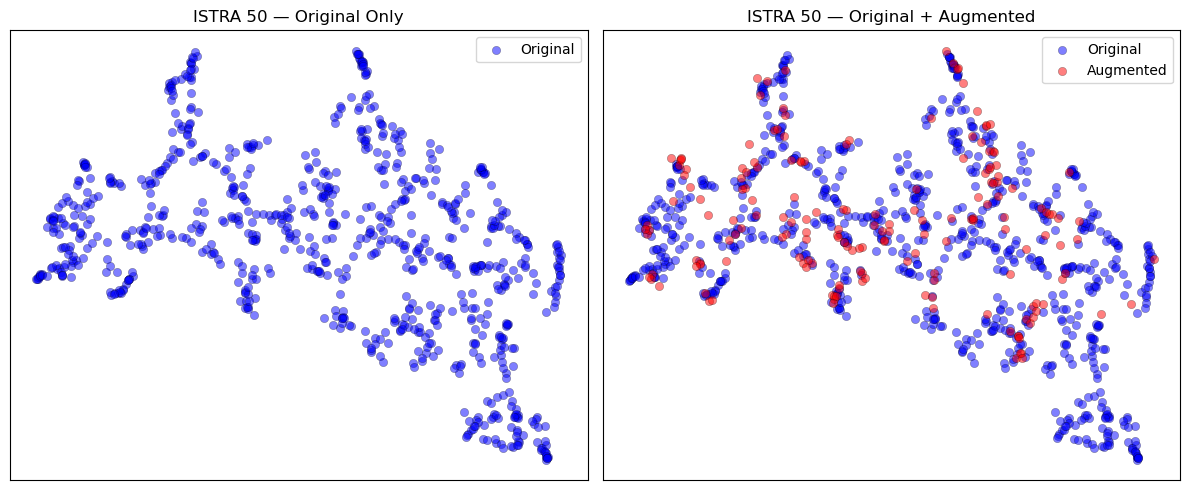


🔍 Processing: ISTRA 45
🧪 Original: 656 | Augmented: 344 | Total: 1000
📈 % Augmented w.r.t. Original: 52.4%
📊 % Augmented w.r.t. Total: 34.4%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


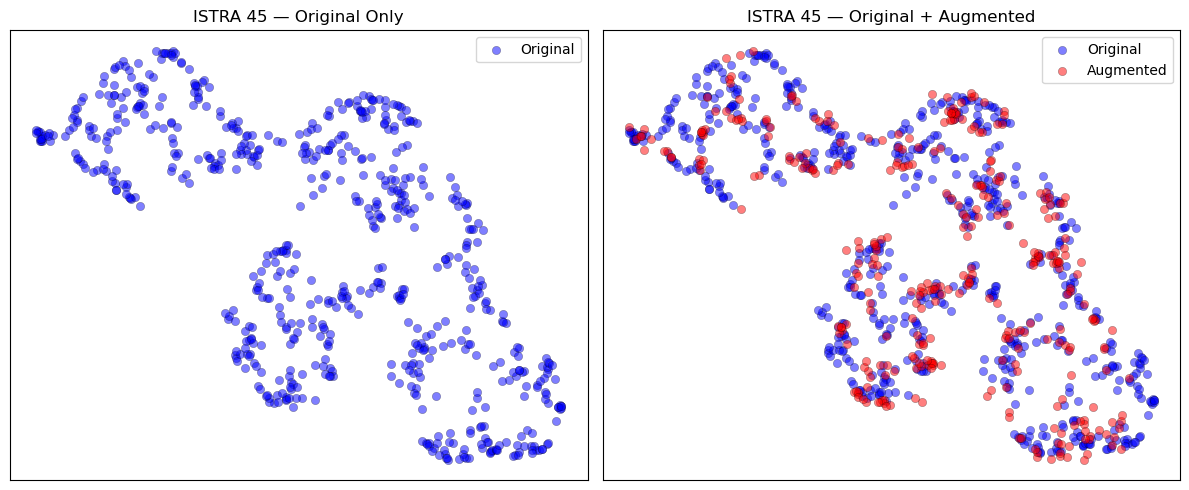


🔍 Processing: ISTRA 50 5.0
🧪 Original: 522 | Augmented: 478 | Total: 1000
📈 % Augmented w.r.t. Original: 91.6%
📊 % Augmented w.r.t. Total: 47.8%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


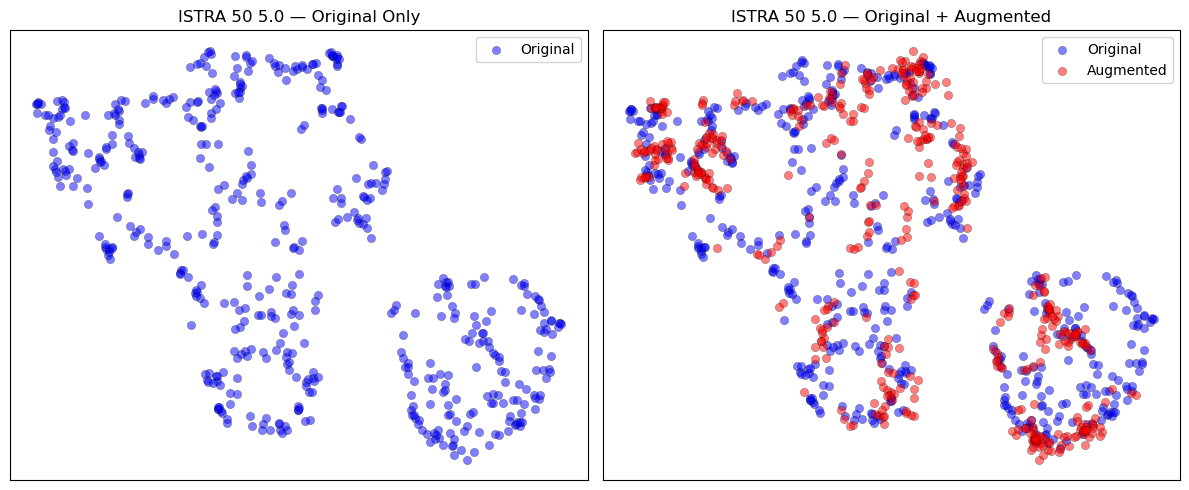


🔍 Processing: Lumnite SG
🧪 Original: 634 | Augmented: 366 | Total: 1000
📈 % Augmented w.r.t. Original: 57.7%
📊 % Augmented w.r.t. Total: 36.6%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


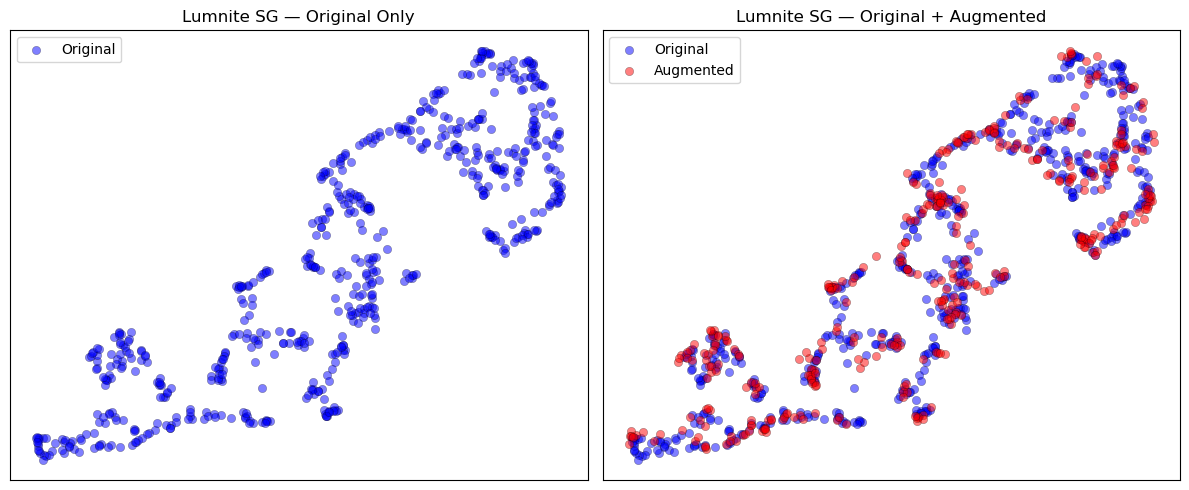


🔍 Processing: Lumnite SG5
🧪 Original: 223 | Augmented: 777 | Total: 1000
📈 % Augmented w.r.t. Original: 348.4%
📊 % Augmented w.r.t. Total: 77.7%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


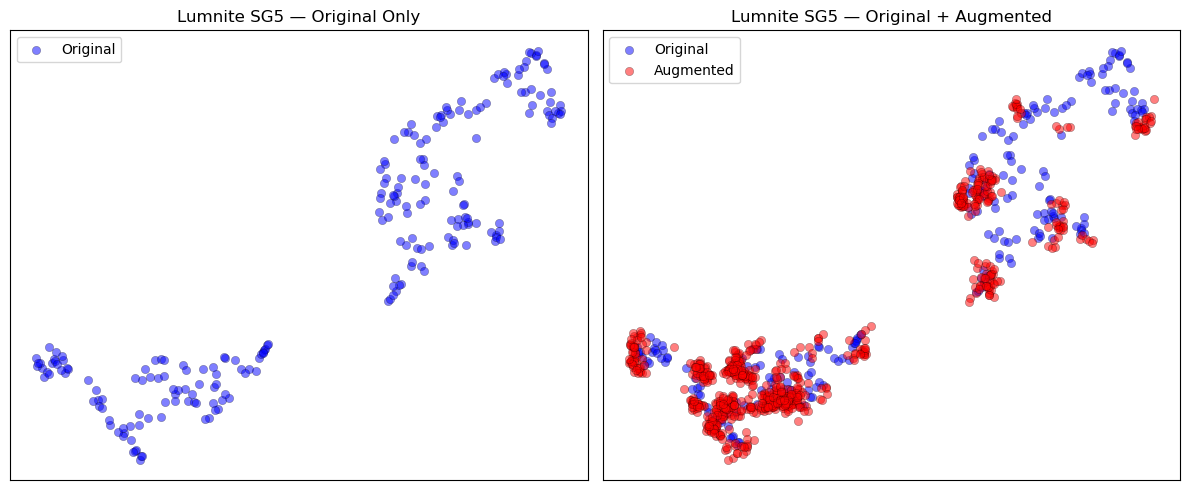


🔍 Processing: CEMFAST
🧪 Original: 337 | Augmented: 663 | Total: 1000
📈 % Augmented w.r.t. Original: 196.7%
📊 % Augmented w.r.t. Total: 66.3%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


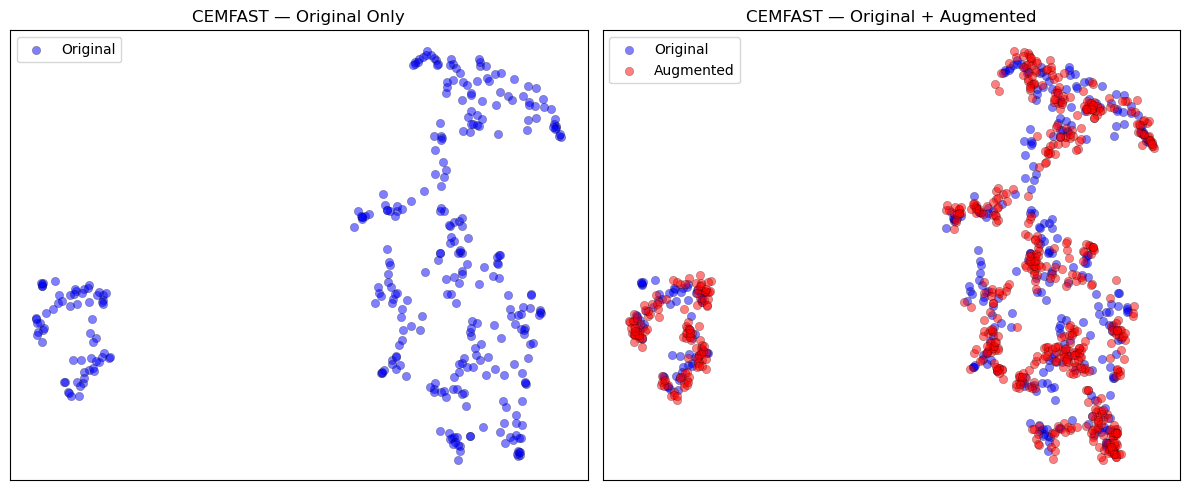


🔍 Processing: ISTRA 40
🧪 Original: 1451 | Augmented: 0 | Total: 1451
📈 % Augmented w.r.t. Original: 0.0%
📊 % Augmented w.r.t. Total: 0.0%


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


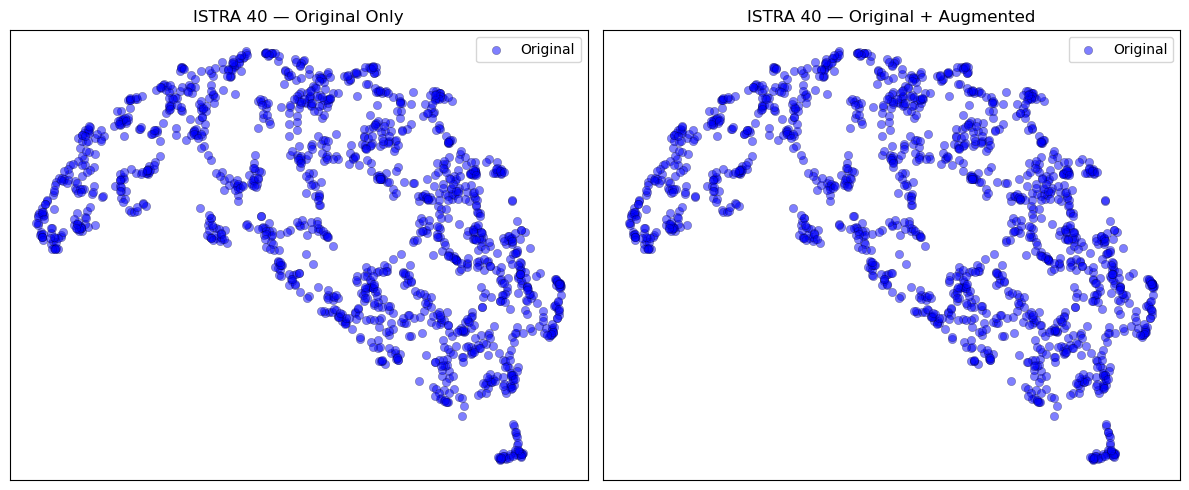

In [ ]:
import umap
import matplotlib.pyplot as plt

# Columns to exclude due to consistent NaNs in augmented data
excluded_ilr_cols = []
add_cols = [f"Chem_{i}" for i in range(1, 12)] + [f"Phase_{i}" for i in range(1, 14)]

# Adjusted feature set
filtered_cols_for_umap = [col for col in all_cols_for_filtering if col not in excluded_ilr_cols]
filtered_cols_for_umap = used_cols

print("🧬 UMAP input features:")
print(filtered_cols_for_umap)

print("\n📉 Plotting UMAP projections using filtered feature set...\n")

for cement_type, df in cement_dfs_ordered.items():

    print(f"\n🔍 Processing: {cement_type}")

    df_orig = df[df["Augmented"] == 0]
    df_aug = df[df["Augmented"] == 1]
    n_orig = len(df_orig)
    n_aug = len(df_aug)
    n_total = len(df)
    pct_aug_of_orig = (n_aug / n_orig) * 100 if n_orig > 0 else 0
    pct_aug_of_total = (n_aug / n_total) * 100 if n_total > 0 else 0

    print(f"🧪 Original: {n_orig} | Augmented: {n_aug} | Total: {n_total}")
    print(f"📈 % Augmented w.r.t. Original: {pct_aug_of_orig:.1f}%")
    print(f"📊 % Augmented w.r.t. Total: {pct_aug_of_total:.1f}%")

    if df_orig.empty:
        print(f"⚠️ Skipping {cement_type} — no original samples.")
        continue

    try:
        X_orig = df_orig[filtered_cols_for_umap].dropna().values
        umap_model = umap.UMAP(n_components=2, random_state=42)
        X_orig_2d = umap_model.fit_transform(X_orig)

        X_aug_2d = np.empty((0, 2))
        df_aug_clean = df_aug.dropna(subset=filtered_cols_for_umap)

        if not df_aug_clean.empty:
            X_aug = df_aug_clean[filtered_cols_for_umap].values
            X_aug_2d = umap_model.transform(X_aug)

        # Plotting side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Left: Only original
        axes[0].scatter(X_orig_2d[:, 0], X_orig_2d[:, 1], c='blue', label='Original', alpha=0.5, edgecolor='black', linewidth=0.3)
        axes[0].set_title(f"{cement_type} — Original Only")
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].legend()
        axes[0].grid(True)

        # Right: Original + Augmented
        axes[1].scatter(X_orig_2d[:, 0], X_orig_2d[:, 1], c='blue', label='Original', alpha=0.5, edgecolor='black', linewidth=0.3)
        if X_aug_2d.shape[0] > 0:
            axes[1].scatter(X_aug_2d[:, 0], X_aug_2d[:, 1], c='red', label='Augmented', alpha=0.5, edgecolor='black', linewidth=0.3)
        axes[1].set_title(f"{cement_type} — Original + Augmented")
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"❌ Missing columns in {cement_type}: {e}")
        continue



In [ ]:
summary_dfs_cleaned = {}

print("📊 Summary of `Process` value proportions (Original vs. Total):\n")

for cement_type, df in cement_dfs_ordered.items():
    if "Augmented" in df.columns:
        df_orig = df[df["Augmented"] == 0]
        print("Augmented")
    else:
        df_orig = df.copy()  # If there's no Augmented column, treat all as original

    df_total = df

    # Value counts as proportions
    orig_counts = df_orig["Process"].value_counts(normalize=True) * 100
    total_counts = df_total["Process"].value_counts(normalize=True) * 100

    # Combine and align
    summary = pd.DataFrame({
        "Original %": orig_counts,
        "Total %": total_counts
    }).fillna(0)

    # Compute delta
    summary["Δ % (Total - Original)"] = summary["Total %"] - summary["Original %"]

    summary_dfs_cleaned[cement_type] = summary.sort_values(by="Total %", ascending=False)

    print(f"\n🔹 {cement_type}")
    display(summary_dfs_cleaned[cement_type].style.format("{:.2f}"))



📊 Summary of `Process` value proportions (Original vs. Total):

Augmented

🔹 ISTRA 50


,Original %,Total %,Δ % (Total - Original)
Process,,,
meljava,57.11,60.90,3.79
otprema,40.83,37.40,-3.43
vanredni uzorak,0.73,0.60,-0.13
uzorak od uzorka,0.61,0.50,-0.11
ostalo,0.49,0.40,-0.09
otprema-IS,0.24,0.20,-0.04


Augmented

🔹 ISTRA 45


,Original %,Total %,Δ % (Total - Original)
Process,,,
meljava,54.27,55.00,0.73
otprema,44.51,44.20,-0.31
vanredni uzorak,0.61,0.40,-0.21
uzorak od uzorka,0.46,0.30,-0.16
ostalo,0.15,0.10,-0.05


Augmented

🔹 ISTRA 50 5.0


,Original %,Total %,Δ % (Total - Original)
Process,,,
otprema,67.62,70.90,3.28
meljava,29.12,27.40,-1.72
vanredni uzorak,1.92,1.00,-0.92
otprema-IS,0.57,0.30,-0.27
ostalo,0.38,0.20,-0.18
uzorak od uzorka,0.38,0.20,-0.18


Augmented

🔹 Lumnite SG


,Original %,Total %,Δ % (Total - Original)
Process,,,
otprema,64.83,68.00,3.17
meljava,33.28,30.80,-2.48
vanredni uzorak,1.26,0.80,-0.46
uzorak od uzorka,0.32,0.20,-0.12
ostalo,0.32,0.20,-0.12


Augmented

🔹 Lumnite SG5


,Original %,Total %,Δ % (Total - Original)
Process,,,
meljava,68.61,81.20,12.59
otprema,30.94,18.70,-12.24
uzorak od uzorka,0.45,0.10,-0.35


Augmented

🔹 CEMFAST


,Original %,Total %,Δ % (Total - Original)
Process,,,
otprema,62.61,69.90,7.29
meljava,33.23,28.70,-4.53
vanredni uzorak,2.08,0.70,-1.38
ostalo,1.19,0.40,-0.79
uzorak od uzorka,0.89,0.30,-0.59


Augmented

🔹 ISTRA 40


,Original %,Total %,Δ % (Total - Original)
Process,,,
meljava,51.00,51.00,0.00
otprema,47.62,47.62,0.00
vanredni uzorak,0.76,0.76,0.00
ostalo,0.41,0.41,0.00
uzorak od uzorka,0.21,0.21,0.00


📊 Plotting side-by-side histograms for each feature...

🔍 Processing: ISTRA 50


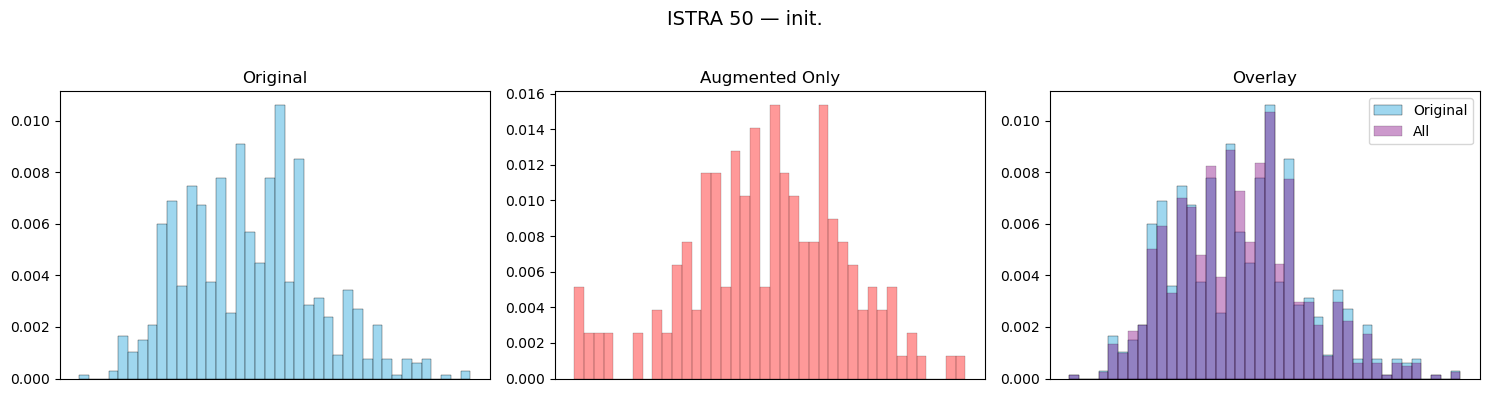

🔍 Processing: ISTRA 45


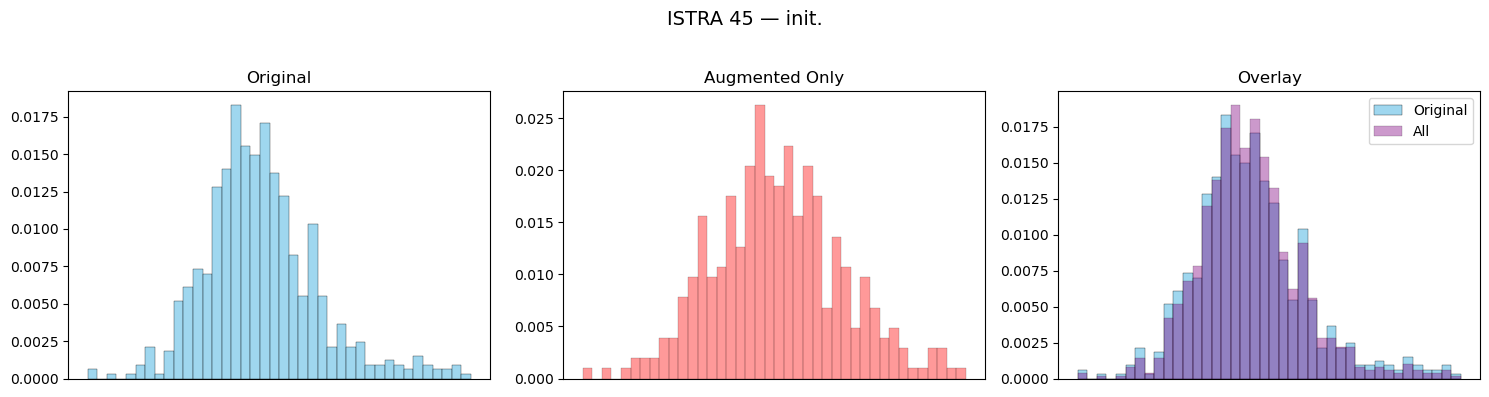

🔍 Processing: ISTRA 50 5.0


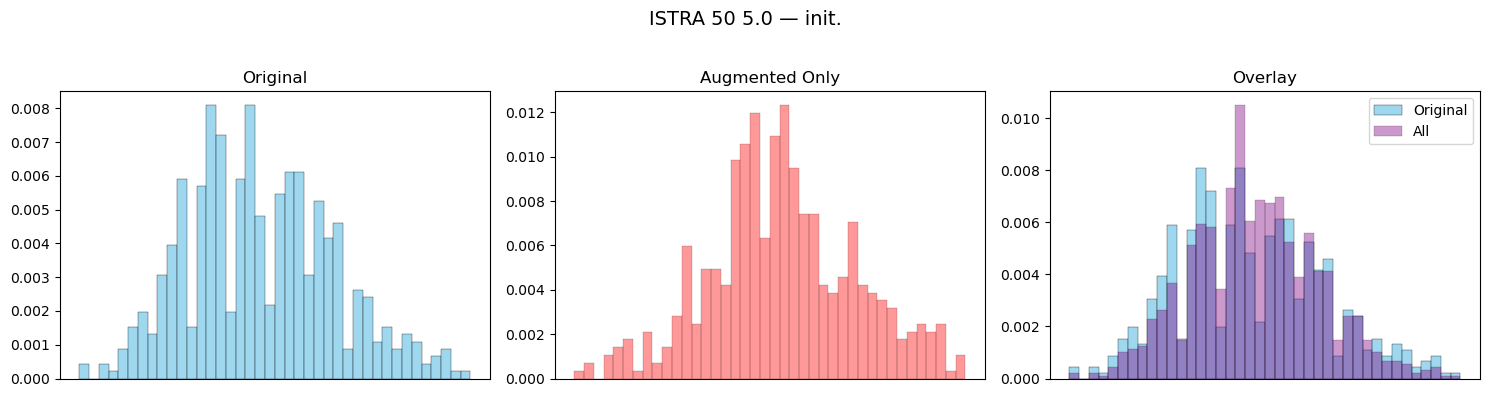

🔍 Processing: ISTRA 40


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


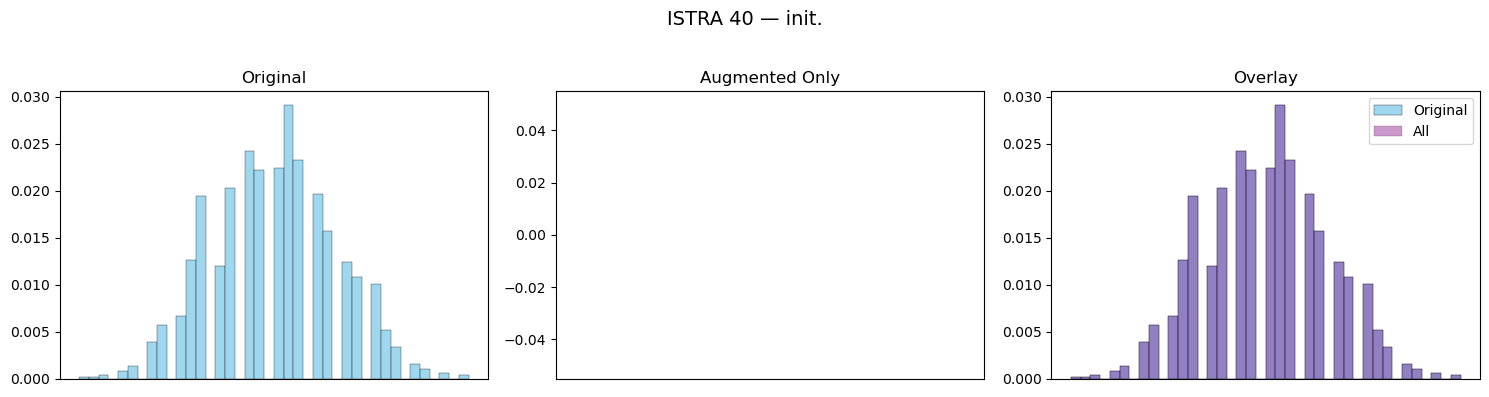

🔍 Processing: Lumnite SG


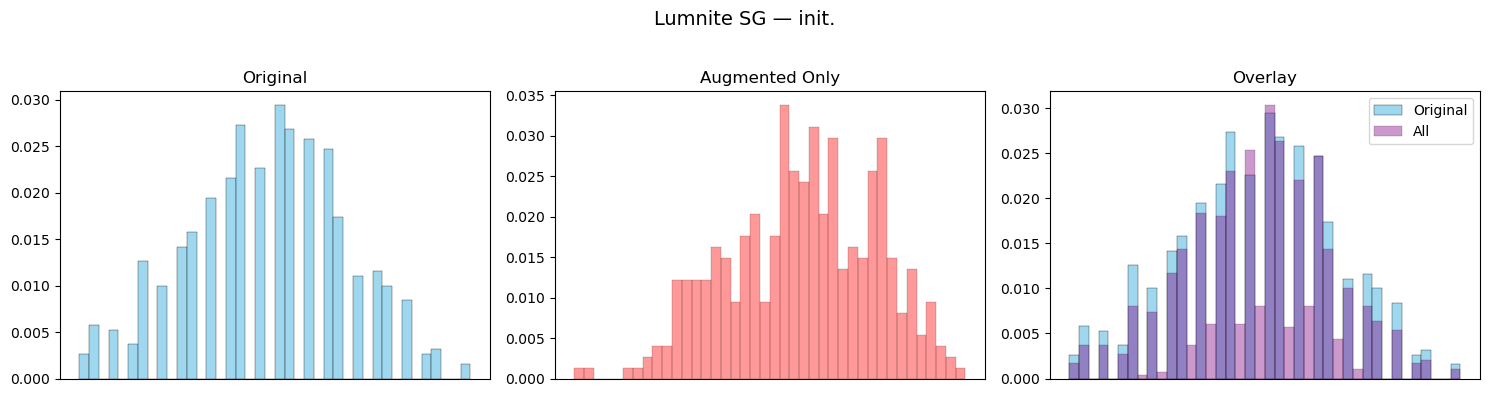

🔍 Processing: CEMFAST


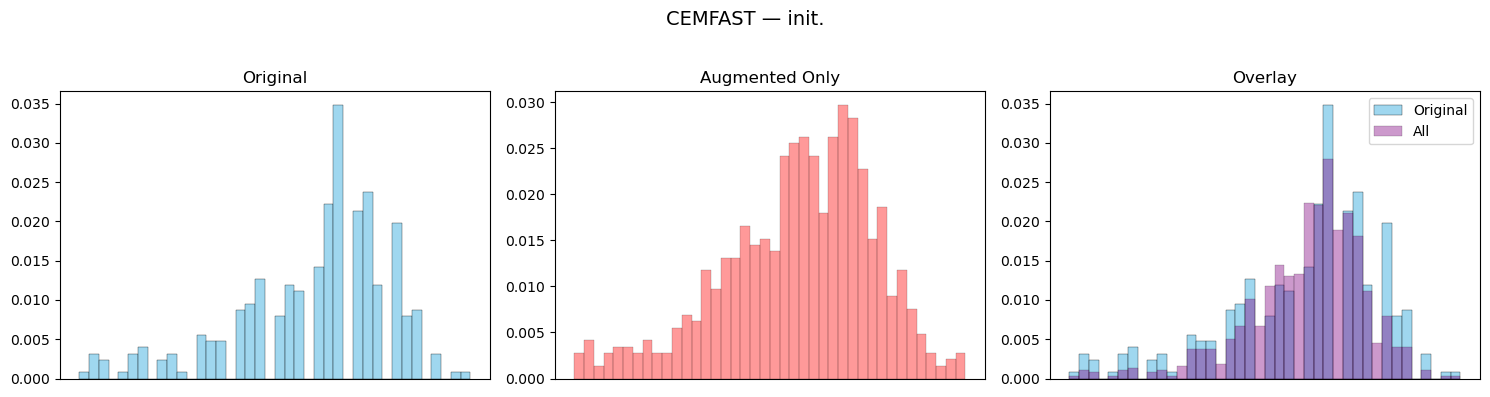

🔍 Processing: Lumnite SG5


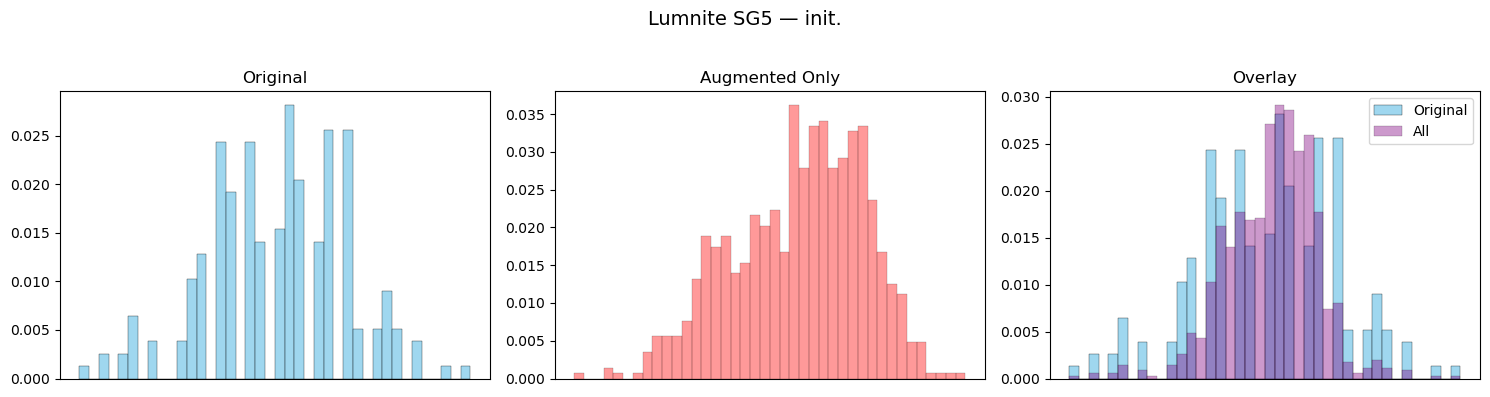

In [ ]:
import matplotlib.pyplot as plt

print("📊 Plotting side-by-side histograms for each feature...\n")

for cement_type, df in cement_dfs_augmented_or.items():
    print(f"🔍 Processing: {cement_type}")

    df_orig = df[df["Augmented"] == 0]
    df_aug = df[df["Augmented"] == 1]
    df_all = df

    all_cols = ['init.']

    for col in all_cols:
        if col not in df.columns:
            print(f"⚠️ Skipping missing column: {col}")
            continue

        if df_orig[col].dropna().empty or df_all[col].dropna().empty:
            print(f"⚠️ Skipping {col} due to all NaNs")
            continue

        bins = 40
        data_orig = df_orig[col].dropna()
        data_aug = df_aug[col].dropna()
        data_all = df_all[col].dropna()

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"{cement_type} — {col}", fontsize=14)

        # Left: Original
        plt.subplot(1, 3, 1)
        plt.hist(data_orig, bins=bins, color="skyblue", edgecolor="black", alpha=0.8, density=True, linewidth=0.3)
        plt.title("Original")
        plt.xticks([])

        # Middle: Augmented
        plt.subplot(1, 3, 2)
        plt.hist(data_aug, bins=bins, color="red", edgecolor="black", alpha=0.4, density=True, linewidth=0.3)
        plt.title("Augmented Only")
        plt.xticks([])

        # Right: Overlay
        plt.subplot(1, 3, 3)
        plt.hist(data_orig, bins=bins, color="skyblue", edgecolor="black", alpha=0.8, density=True, linewidth=0.3, label="Original")
        plt.hist(data_all, bins=bins, color="purple", edgecolor="black", alpha=0.4, density=True, linewidth=0.3, label="All")
        plt.title("Overlay")
        plt.legend()
        plt.xticks([])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



🧩 Cluster columns used:
['H2O(Humidity)', 'Ignition Loss', 'L', 'a', 'b', '90', 'Blaine', 'BlaineS', 'd10', 'd50', 'd63', 'd90', 'n', '305', '454', '753', '902', 'Chem_1', 'Chem_2', 'Chem_3', 'Chem_4', 'Chem_5', 'Chem_6', 'Chem_7', 'Chem_8', 'Chem_9', 'Chem_10', 'Chem_11', 'Chem_ilr_1', 'Chem_ilr_2', 'Chem_ilr_3', 'Chem_ilr_4', 'Chem_ilr_5', 'Chem_ilr_6', 'Chem_ilr_7', 'Chem_ilr_8', 'Chem_ilr_9', 'Chem_ilr_10', 'Phase_1', 'Phase_2', 'Phase_3', 'Phase_4', 'Phase_5', 'Phase_6', 'Phase_7', 'Phase_8', 'Phase_9', 'Phase_10', 'Phase_11', 'Phase_12', 'Phase_13', 'Phase_ilr_1', 'Phase_ilr_2', 'Phase_ilr_3', 'Phase_ilr_4', 'Phase_ilr_5', 'Phase_ilr_6', 'Phase_ilr_7', 'Phase_ilr_8', 'Phase_ilr_9', 'Phase_ilr_10', 'Phase_ilr_11', 'Phase_ilr_12', 'R_profile', 'G.O.F.', 'water', 'plumb']


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availab

🔍 k=4 | Silhouette=0.3382 | Inertia=11058093.54
🔍 k=5 | Silhouette=0.3189 | Inertia=9315191.93
🔍 k=6 | Silhouette=0.3439 | Inertia=7649471.62


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


🔍 k=7 | Silhouette=0.3551 | Inertia=6581144.57
🔍 k=8 | Silhouette=0.3437 | Inertia=5863127.21
🔍 k=9 | Silhouette=0.3391 | Inertia=5506110.86


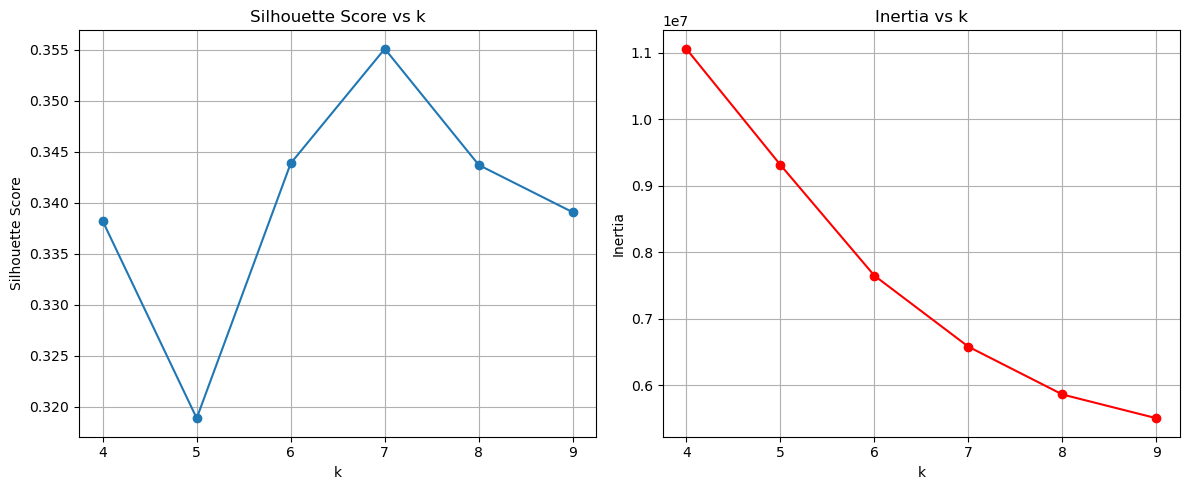


✅ Best k based on Silhouette Score: 7


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


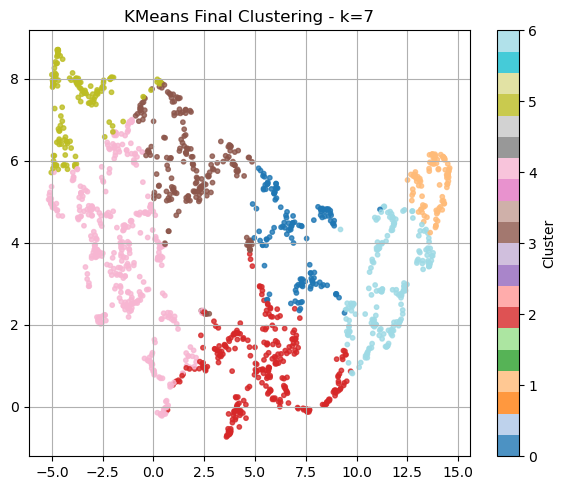

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use the cleaned dataset (no overwriting)
df_istra40_cleaned = cement_dfs_ordered["ISTRA 40"].copy()

# Remove columns that end with _cluster
df_istra40_cleaned = df_istra40_cleaned[[col for col in df_istra40_cleaned.columns if not col.endswith("_cluster")]]

# Select numerical columns for clustering
cluster_features_istra40 = [
    col for col in df_istra40_cleaned.columns
    if col not in ["Date", "Type", "Process", "Augmented", "init.", "Cluster"]
    and df_istra40_cleaned[col].dtype in [float, int]
]
print("🧩 Cluster columns used:")
print(cluster_features_istra40)

# Drop NaNs
X_cluster_istra40 = df_istra40_cleaned[cluster_features_istra40].dropna()

# UMAP projection
umap_model_istra40 = umap.UMAP(n_components=2, random_state=42)
X_2d_istra40 = umap_model_istra40.fit_transform(X_cluster_istra40)

# Try different k
kmeans_results = []
for k in range(4, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_cluster_istra40)
    sil_score = silhouette_score(X_cluster_istra40, labels)
    inertia = kmeans.inertia_
    kmeans_results.append((k, sil_score, inertia))
    print(f"🔍 k={k} | Silhouette={sil_score:.4f} | Inertia={inertia:.2f}")

# Results DataFrame
df_kmeans_results = pd.DataFrame(kmeans_results, columns=["k", "silhouette", "inertia"])

# Plot Silhouette and Inertia
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(df_kmeans_results["k"], df_kmeans_results["silhouette"], marker='o')
ax[0].set_title("Silhouette Score vs k")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Silhouette Score")
ax[0].grid(True)

ax[1].plot(df_kmeans_results["k"], df_kmeans_results["inertia"], marker='o', color="red")
ax[1].set_title("Inertia vs k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Inertia")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Best k
best_k_istra40 = df_kmeans_results.sort_values(by="silhouette", ascending=False).iloc[0]["k"]
print(f"\n✅ Best k based on Silhouette Score: {int(best_k_istra40)}")

# Final clustering
final_kmeans_istra40 = KMeans(n_clusters=int(best_k_istra40), random_state=42, n_init="auto")
istra40_cluster_labels = final_kmeans_istra40.fit_predict(X_cluster_istra40)

# Final UMAP plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_2d_istra40[:, 0], X_2d_istra40[:, 1], c=istra40_cluster_labels, cmap="tab20", s=10, alpha=0.8)
plt.title(f"KMeans Final Clustering - k={int(best_k_istra40)}")
plt.xlabel("")
plt.ylabel("")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()




📐 Shape of X_cluster_istra40: (1451, 67)
📐 Shape of df_istra40_clustered (source for trimming): (1451, 72)
📐 Final trimmed DataFrame shape: (1003, 72)


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\npedrosa\AppData\Local\Temp\ipykernel_10352\1389196407.py:64: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


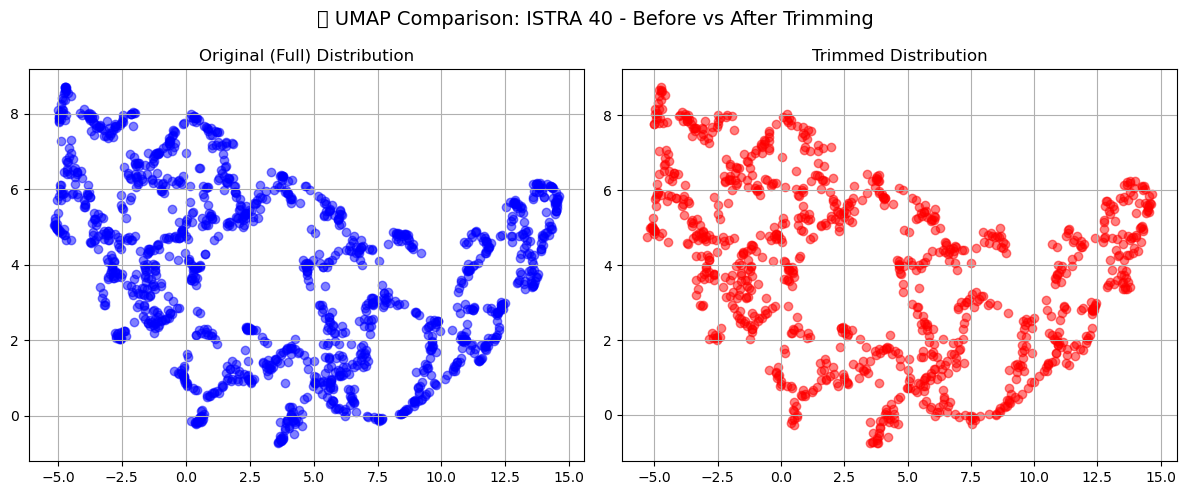

In [ ]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
import umap
from sklearn.utils import resample

# Get cleaned data and cluster labels
df_istra40_cleaned = cement_dfs_ordered["ISTRA 40"].copy()
df_istra40_clustered = df_istra40_cleaned.loc[X_cluster_istra40.index].copy()
df_istra40_clustered["Cluster"] = istra40_cluster_labels

print(f"📐 Shape of X_cluster_istra40: {X_cluster_istra40.shape}")
print(f"📐 Shape of df_istra40_clustered (source for trimming): {df_istra40_clustered.shape}")

# Calculate joint distribution of Cluster and Process
joint_dist_istra40 = df_istra40_clustered.groupby(["Cluster", "Process"]).size() / len(df_istra40_clustered)
target_size_istra40 = 1000
joint_targets_istra40 = (joint_dist_istra40 * target_size_istra40).round().astype(int)

# Generate balanced trimmed dataset
istra40_trimmed_parts = []
for (cluster_label, process_label), count in joint_targets_istra40.items():
    subset = df_istra40_clustered[
        (df_istra40_clustered["Cluster"] == cluster_label) &
        (df_istra40_clustered["Process"] == process_label)
    ]
    if subset.empty:
        continue
    if len(subset) >= count:
        trimmed_subset = subset.sample(n=count, random_state=42)
    else:
        trimmed_subset = resample(subset, n_samples=count, replace=True, random_state=42)
    istra40_trimmed_parts.append(trimmed_subset)

# Combine and shuffle
df_istra40_trimmed_stratified = pd.concat(istra40_trimmed_parts).sample(frac=1, random_state=42)
print(f"📐 Final trimmed DataFrame shape: {df_istra40_trimmed_stratified.shape}")

# ─────────────── UMAP VISUALIZATION ─────────────── #

umap_model_istra40 = umap.UMAP(n_components=2, random_state=42)

X_umap_orig = umap_model_istra40.fit_transform(df_istra40_clustered[cluster_features_istra40].dropna())
X_umap_trimmed = umap_model_istra40.transform(df_istra40_trimmed_stratified[cluster_features_istra40].dropna())

plt.figure(figsize=(12, 5))

# Left: Original full UMAP
plt.subplot(1, 2, 1)
plt.scatter(X_umap_orig[:, 0], X_umap_orig[:, 1], c='blue', label='Original', alpha=0.5)
plt.title("Original (Full) Distribution")
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Right: Trimmed 1000-point UMAP
plt.subplot(1, 2, 2)
plt.scatter(X_umap_trimmed[:, 0], X_umap_trimmed[:, 1], c='red', label='Trimmed (1000)', alpha=0.5)
plt.title("Trimmed Distribution")
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

plt.suptitle("🔍 UMAP Comparison: ISTRA 40 - Before vs After Trimming", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warni

📐 Final trimmed (Mahalanobis) shape: (1003, 72)


C:\Users\npedrosa\AppData\Local\Temp\ipykernel_10352\2881180297.py:81: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


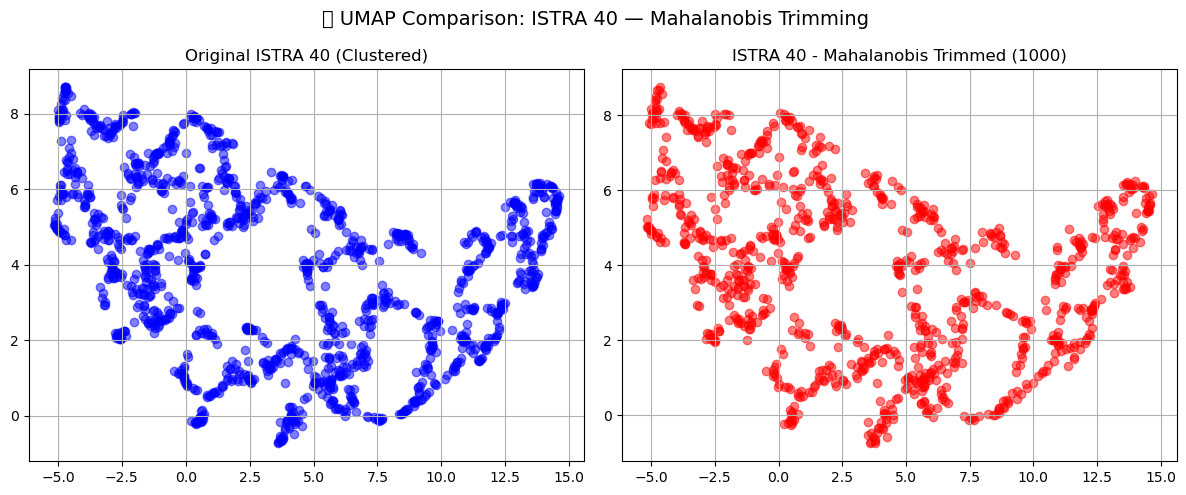

In [ ]:
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Step 1: Prepare working DataFrame with cluster labels
df_istra40_cleaned = cement_dfs_ordered["ISTRA 40"].copy()
df_istra40_clustered_maha = df_istra40_cleaned.loc[X_cluster_istra40.index].copy()
df_istra40_clustered_maha["Cluster"] = istra40_cluster_labels

trim_cluster_cols_maha = [
    col for col in df_istra40_clustered_maha.columns
    if col not in ["Date", "Type", "Process", "Augmented", "init.", "Cluster"]
    and df_istra40_clustered_maha[col].dtype in [float, int]
]

# Step 2: Compute joint distribution
joint_dist_maha = df_istra40_clustered_maha.groupby(["Cluster", "Process"]).size()
joint_dist_maha = joint_dist_maha / joint_dist_maha.sum()
target_maha_size = 1000
joint_targets_maha = (joint_dist_maha * target_maha_size).round().astype(int)

# Step 3: Trim using Mahalanobis distance
maha_parts = []
for (clust, proc), count in joint_targets_maha.items():
    group = df_istra40_clustered_maha[
        (df_istra40_clustered_maha["Cluster"] == clust) &
        (df_istra40_clustered_maha["Process"] == proc)
    ]
    if group.empty:
        continue

    if len(group) <= count:
        maha_parts.append(group)
        continue

    X_group = group[trim_cluster_cols_maha].values
    try:
        mcd = MinCovDet().fit(X_group)
        center = mcd.location_
        cov_inv = np.linalg.pinv(mcd.covariance_)  # Robust to singular matrices
        dists = [mahalanobis(x, center, cov_inv) for x in X_group]
    except Exception as e:
        print(f"⚠️ Skipping Cluster={clust}, Process={proc}: {e}")
        continue

    group = group.copy()
    group["mahalanobis"] = dists
    best = group.nsmallest(count, "mahalanobis").drop(columns="mahalanobis")
    maha_parts.append(best)

# Step 4: Combine and report
df_istra40_trimmed_maha = pd.concat(maha_parts)
print(f"📐 Final trimmed (Mahalanobis) shape: {df_istra40_trimmed_maha.shape}")

# ─────────────── UMAP VISUALIZATION ─────────────── #

umap_model_maha = umap.UMAP(n_components=2, random_state=42)

X_umap_orig_maha = umap_model_maha.fit_transform(df_istra40_clustered_maha[trim_cluster_cols_maha].dropna())
X_umap_trim_maha = umap_model_maha.transform(df_istra40_trimmed_maha[trim_cluster_cols_maha].dropna())

plt.figure(figsize=(12, 5))

# Original
plt.subplot(1, 2, 1)
plt.scatter(X_umap_orig_maha[:, 0], X_umap_orig_maha[:, 1], c='blue', alpha=0.5)
plt.title("Original ISTRA 40 (Clustered)")
plt.grid(True)

# Trimmed
plt.subplot(1, 2, 2)
plt.scatter(X_umap_trim_maha[:, 0], X_umap_trim_maha[:, 1], c='red', alpha=0.5)
plt.title("ISTRA 40 - Mahalanobis Trimmed (1000)")
plt.grid(True)

plt.suptitle("🔍 UMAP Comparison: ISTRA 40 — Mahalanobis Trimming", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
import pandas as pd
import numpy as np
cluster_cols = cluster_features_istra40
# Define datasets and name map
trim_methods = {
    "Random-Stratified": df_istra40_trimmed_stratified,
    "Mahalanobis-Based": df_istra40_trimmed_maha
}

df_original = cement_dfs_ordered["ISTRA 40"]
X_orig = df_original[cluster_cols].dropna().copy()

# Fit global MCD model on original data
mcd_orig = MinCovDet().fit(X_orig.values)
center_orig = mcd_orig.location_
cov_inv_orig = np.linalg.pinv(mcd_orig.covariance_)

# Compute baseline: self-to-self distance (as a lower bound reference)
baseline_mahal_dists = [mahalanobis(x, center_orig, cov_inv_orig) for x in X_orig.values]
baseline_mahal_mean = np.mean(baseline_mahal_dists)

# Compute baseline univariate Wasserstein distances (leave-one-out-like)
baseline_univ = []
for col in cluster_cols:
    baseline_univ.append(0.0)  # Perfect match to itself
baseline_univ_mean = np.mean(baseline_univ)

# Store results
univariate_results = {}
multivariate_results = {}

print("📊 Comparison to Original Distribution:\n")

for name, df in trim_methods.items():
    X_trim = df[cluster_cols].dropna().copy()

    # ── Univariate Wasserstein Distance ──
    univ_dists = []
    for col in cluster_cols:
        dist = wasserstein_distance(X_orig[col], X_trim[col])
        univ_dists.append((col, dist))
    univ_df = pd.DataFrame(univ_dists, columns=["Feature", "Wasserstein Distance"])
    mean_univ = univ_df["Wasserstein Distance"].mean()
    rel_univ_change = mean_univ / (baseline_univ_mean + 1e-8) * 100  # avoid div0
    univariate_results[name] = (univ_df, mean_univ, rel_univ_change)

    # ── Multivariate Mahalanobis Distance ──
    trim_dists = [mahalanobis(x, center_orig, cov_inv_orig) for x in X_trim.values]
    mean_mahal = np.mean(trim_dists)
    rel_mahal_change = mean_mahal / baseline_mahal_mean * 100
    multivariate_results[name] = (mean_mahal, rel_mahal_change)

    print(f"🔹 {name}")
    print(f"   - Mean Univariate Wasserstein Distance: {mean_univ:.4f} ({rel_univ_change:.1f}% of baseline)")
    print(f"   - Mean Multivariate Mahalanobis Distance: {mean_mahal:.4f} ({rel_mahal_change:.1f}% of baseline)")

# ── Judgment ──
print("\n🏁 Final Judgment:")

best_univ = min(univariate_results.items(), key=lambda x: x[1][1])[0]
best_mahal = min(multivariate_results.items(), key=lambda x: x[1][0])[0]

print(f"✅ Better Univariate Fit: {best_univ}")
print(f"✅ Better Multivariate Fit: {best_mahal}")



C:\Users\npedrosa\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


📊 Comparison to Original Distribution:

🔹 Random-Stratified
   - Mean Univariate Wasserstein Distance: 0.0618 (618189832.5% of baseline)
   - Mean Multivariate Mahalanobis Distance: 15.9651 (96.3% of baseline)
🔹 Mahalanobis-Based
   - Mean Univariate Wasserstein Distance: 0.0881 (881427718.4% of baseline)
   - Mean Multivariate Mahalanobis Distance: 13.4818 (81.4% of baseline)

🏁 Final Judgment:
✅ Better Univariate Fit: Random-Stratified
✅ Better Multivariate Fit: Mahalanobis-Based


In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Start with the Mahalanobis-trimmed version
df_final = df_istra40_trimmed_stratified.copy()

# Ensure exactly 1000 samples
if len(df_final) > 1000:
    print(f"⚠️ Trimming {len(df_final) - 1000} redundant samples from ISTRA 40...")

    # Use the same features used for clustering
    X = df_final[cluster_features_istra40].values

    # Compute pairwise distances
    dists = pairwise_distances(X)
    np.fill_diagonal(dists, np.inf)  # Ignore self-distance

    # Get most similar pairs
    similar_pairs = np.unravel_index(np.argsort(dists, axis=None), dists.shape)
    top_pairs = list(zip(similar_pairs[0], similar_pairs[1]))

    # Remove second point from the most similar pairs
    to_remove = set()
    for i, j in top_pairs:
        if j not in to_remove and len(to_remove) < (len(df_final) - 1000):
            to_remove.add(j)

    df_final = df_final.drop(index=df_final.index[list(to_remove)])
    print(f"✅ Trimmed down to {len(df_final)} samples.")

elif len(df_final) < 1000:
    raise ValueError(f"❌ Dataset has only {len(df_final)} samples, expected 1000.")

# Store into cleaned dictionary
cement_dfs_ordered["ISTRA 40"] = df_final.copy()
print(f"✅ 'ISTRA 40' updated in cement_dfs_ordered with exactly 1000 samples.")



⚠️ Trimming 3 redundant samples from ISTRA 40...
✅ Trimmed down to 1000 samples.
✅ 'ISTRA 40' updated in cement_dfs_ordered with exactly 1000 samples.


In [ ]:
print("📐 Dataset Shapes by Cement Type:\n")

for cement_type, data in cement_final_split.items():
    print(f"🔹 {cement_type}:")
    print(f"   - X_train: {data['X_train'].shape}")
    print(f"   - y_train: {data['y_train'].shape}")
    print(f"   - X_test : {data['X_test'].shape}")
    print(f"   - y_test : {data['y_test'].shape}")


📐 Dataset Shapes by Cement Type:

🔹 ISTRA 50:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (207, 70)
   - y_test : (207,)
🔹 ISTRA 45:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (177, 70)
   - y_test : (177,)
🔹 ISTRA 50 5.0:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (145, 70)
   - y_test : (145,)
🔹 Lumnite SG:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (168, 70)
   - y_test : (168,)
🔹 Lumnite SG5:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (62, 70)
   - y_test : (62,)
🔹 CEMFAST:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (85, 70)
   - y_test : (85,)
🔹 ISTRA 40:
   - X_train: (1000, 70)
   - y_train: (1000,)
   - X_test : (381, 70)
   - y_test : (381,)


In [ ]:
def add_chem_phase_ratios(df):
    df = df.copy()

    chem_cols = [col for col in df.columns if col.startswith("Chem_") and "_ilr" not in col]
    phase_cols = [col for col in df.columns if col.startswith("Phase_") and "_ilr" not in col]

    new_features = {}

    # Chem–chem ratios
    for c1, c2 in itertools.combinations(chem_cols, 2):
        for num, denom in [(c1, c2), (c2, c1)]:
            name = f"{num}_div_{denom}"
            new_features[name] = df[num] / (df[denom] + 1e-6)

    # Phase–phase ratios
    for p1, p2 in itertools.combinations(phase_cols, 2):
        for num, denom in [(p1, p2), (p2, p1)]:
            name = f"{num}_div_{denom}"
            new_features[name] = df[num] / (df[denom] + 1e-6)

    # Chem–Phase cross ratios
    for c, p in itertools.product(chem_cols, phase_cols):
        name = f"{c}_div_{p}"
        new_features[name] = df[c] / (df[p] + 1e-6)

    # Totals
    new_features["chem_total"] = df[chem_cols].sum(axis=1)
    new_features["phase_total"] = df[phase_cols].sum(axis=1)

    # Domain-specific ratios (all using _div_ naming)
    if "H2O(Humidity)" in df.columns and "Ignition Loss" in df.columns:
        new_features["H2O(Humidity)_div_Ignition_Loss"] = df["H2O(Humidity)"] / (df["Ignition Loss"] + 1e-6)

    if "Blaine" in df.columns and "d50" in df.columns:
        new_features["Blaine_div_d50"] = df["Blaine"] / (df["d50"] + 1e-6)

    if "d10" in df.columns and "d90" in df.columns:
        new_features["d10_div_d90"] = df["d10"] / (df["d90"] + 1e-6)

    if "L" in df.columns and "a" in df.columns and "b" in df.columns:
        new_features["L_div_a_plus_b"] = df["L"] / (df["a"] + df["b"] + 1e-6)
        new_features["whiteness"] = np.sqrt(df["L"]**2 + df["a"]**2 + df["b"]**2)

    if "BlaineS" in df.columns and "Blaine" in df.columns:
        new_features["BlaineS_div_Blaine"] = df["BlaineS"] / (df["Blaine"] + 1e-6)

    if "water" in df.columns:
        new_features["chem_total_div_water"] = new_features["chem_total"] / (df["water"] + 1e-6)

    # Add all new features at once to avoid fragmentation
    df = pd.concat([df, pd.DataFrame(new_features, index=df.index)], axis=1)

    return df
